In [1]:
## Import required packages, global parameters

%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as xccrs
import cartopy.feature as cfeature
# import xesmf as xe
%matplotlib inline
import momlevel
import datetime as dt
import xeofs
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from mypyutils import colormap_utils as mycolors
mdates.MonthLocator(bymonthday=15)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'serif',
    "font.serif": 'Computer Modern'
})    

cols=['k','C1','C0','C2','C3','C4','C5','C6']   
panellabs=list(map(chr, range(97, 112)))
# panellabs

In [2]:
import sys
sys.path.append("./../NSF-OCE_2148596/notebooks/pacific_HRDP_DPLE/lfca/Python")
import scipy as sp
from scipy import io
from signal_processing import lfca

In [3]:
def tg_lfca(da, cutoff, truncation):
    lat_axis = da.tgindex.values
    time = da.time.values
    sst = da.to_numpy().squeeze()
    nlat = da.shape[1]
    ntime = da.shape[0]
    x = da.values
    area_weights = da[0, :] * 0 + 1
    area_weights = np.expand_dims(area_weights, axis=0)
    area_weights
    normvec = np.transpose(area_weights) / np.sum(area_weights)
    scale = np.sqrt(normvec)
    (
        lfcs,
        lfps,
        weights,
        r,
        pvar,
        pcs,
        eofs,
        ntr,
        pvar_slow,
        pvar_lfc,
        r_eofs,
        pvar_slow_eofs,
        lf_ts,
    ) = lfca(x, cutoff, truncation, scale)

    return lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts

In [4]:
lines = ["-","--",":",":"]

In [5]:
def calc_power(pc1):
    import statsmodels.api as sm
    import numpy as np
    import scipy.stats as stats
    
    fs = len(pc1) # Sampling frequency
    t = np.arange(0, len(pc1),1)  # Time vector
    x=np.array(pc1)

    fs=1
    nperseg=32#384/2=192 96
    nfft = nperseg*2
    noverlap = nperseg/2
    
    f, Pxx_den = signal.welch(x,window='hann', fs=fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
    
    # Create lagged data
    y = x[1:]
    x = x[:-1]
    
    # Fit a linear regression model
    x = sm.add_constant(x)  # Add constant for intercept
    model = sm.OLS(y, x).fit()
    
    # Get the AR(1) coefficient
    ar_coef = model.params[1]
    ar_coef
    Pxx_den = Pxx_den/np.sum(Pxx_den)
    
    T = nfft       #length of time series
    alpha = ar_coef     #red noise lag-one autocorrelation
    beta = np.sqrt(1.-alpha**2)  #beta, red noise parameter
    
    T2 = T/2
    freq = np.arange(0.,T2+1.)/T
    
    rspec = []
    for h in np.arange(0,T2+1,1):
        rspec.append((1.-alpha**2)/(1.-2.*alpha*np.cos(np.pi*(h)/T2)+alpha**2))
        
    for ir in np.arange(0,500):
        
        # construct synthetic time series (note the f for the cosine wave is approximate 0.2)
        x[0] = beta*np.random.randn()
        for j in np.arange(1,T,1):
            x[j] = x[j-1]*alpha + beta*np.random.randn()+np.cos(2.*np.pi*(1.-0.01*np.random.randn())*50./256.*j)
        # print(x)    
        # compute power spectrum
        p = signal.welch(x.T,window='hann', fs=fs, nperseg=nfft, noverlap=noverlap)#, nperseg=T);
        if(ir==0):
            psum = p[1]
        else:
            # add power spectra for each realization together
            psum = psum + p[1]
    
        # calculate average    
    pave = psum/(ir+1.0)
    
    # normalize the spectrum
    # pave = pave/np.sum(pave)
    
        # calculate significance using F-test
    dof = 2.*(ir+1.)
    
    # # construct synthetic time series (note the f for the cosine wave is approximate 0.2)
    # x[0] = beta*np.random.randn()
    # for j in np.arange(1,T,1):
    #     x[j] = x[j-1]*alpha + beta*np.random.randn()+0.5*np.cos(2.*np.pi*(0.99*np.random.randn())*50./256.*j)
    
    # # compute power spectrum
    # p = signal.welch(x,window='hann', fs=fs)#, nperseg=nfft, noverlap=noverlap)
    # pave = p[1]
    
    # # normalize the spectrum
    # pave = pave/np.sum(pave)
    
    # # calculate significance using F-test
    # dof = 2
    
    fstat = stats.f.ppf(.95,dof,1000)
    spec99 = [fstat*m for m in rspec]

    return Pxx_den,f,freq,rspec,spec99

In [6]:
def butter_bpfilt_high(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='high')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_band(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1, fc2], fs=fs, btype='band')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_low(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='low')
    return signal.filtfilt(b, a, x)

def filtfilt_bpbutter_2d_band(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_band,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt
def filtfilt_bpbutter_2d_high(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_high,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt
    
def filtfilt_bpbutter_2d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt    
    
def filtfilt_bpbutter_3d_band(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_band,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["nlat","nlon","time"], [], [], [], []],  # regrid
        output_core_dims=[["nlat","nlon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt

def filtfilt_bpbutter_3d_high(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_high,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["nlat","nlon","time"], [], [], [], []],  # regrid
        output_core_dims=[["nlat","nlon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt
def filtfilt_bpbutter_3d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["lat","lon","time"], [], [], [], []],  # regrid
        output_core_dims=[["lat","lon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt

In [7]:
#processing functions

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    # print(x)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)
    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
        
    # print(x)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    # print(x,y)
    n     = x.shape[0]
    xmean = x.mean(axis=0, skipna=False)
    ymean = y.mean(axis=0, skipna=False)
    xstd  = x.std(axis=0, skipna=False)
    ystd  = y.std(axis=0, skipna=False)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    # pval   = t.sf(tstats, n-2)*2
    pval = t.sf(abs(tstats), n-2)*2 #corrected
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [8]:
# # Get depth
# diri = '/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI/HR/g.e20.G.TL319_t13.control.001/ocn/hist/'
# dfile=diri+'g.e20.G.TL319_t13.control.001.pop.h.0027-03-06.nc' 

# def preproc(d0):
#     d0 = d0[["HT","TAREA"]]
#     return d0
    
# ds = xr.open_mfdataset(
#     dfile,
#     combine="by_coords",
#     coords="minimal",
#     compat="override",
#     preprocess=preproc,
#     parallel=True,
# )
# hrdepthglobal = ds.HT / 100
# ylo=1350; yhi=2100; xlo=0; xhi=1200; #HR2 EC
# depth=hrdepthglobal.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))
# cellarea=ds.TAREA.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))

In [9]:
tgs_in=pd.read_pickle("tgs_in_93_22.pkl") ##detrended
tgcsvin="./tgs_in_93_22.csv" #need to read in from csv for momlevel
tgnames=tgs_in['name2'].str.replace(r"\(.*\)","").str.replace(r"\,.*","").str.replace(r"\-.*","").str.replace(r"\/.*","").str.title()
shortname=tgnames.str.split('(').str[0]
shortname=shortname.str.split(',').str[0]
shortname

name
497        Port Isabel
538           Rockport
526         Grand Isle
161       Galveston Ii
1193      Apalachicola
246          Pensacola
520     St. Petersburg
188           Key West
395       Fort Pulaski
234       Charleston I
396         Wilmington
2295          Beaufort
299      Sewells Point
1295      Cambridge Ii
1153          Cape May
12           New York 
351            Newport
183         Portland  
Name: name2, dtype: object

In [10]:
xr_tg=xr.open_dataset('/glade/work/clittle/p2679/tgs_usec_93_22.nc') 
hr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs_det.nc')
hr_m_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs_m-r_det.nc')
hr_b_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs_b_det.nc')
lr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_lr_ssh_tgs_det.nc')

xr_tg=xr_tg.ssh
hr_tg=hr_tg.ssh-hr_tg.ssh.mean(dim='time')
hr_tg['time']=xr_tg.time
hr_m_tg=hr_m_tg.ssh-hr_m_tg.ssh.mean(dim='time')
hr_m_tg['time']=xr_tg.time
hr_b_tg=hr_b_tg.ssh-hr_b_tg.ssh.mean(dim='time')
hr_b_tg['time']=xr_tg.time
lr_tg=lr_tg.ssh-lr_tg.ssh.mean(dim='time')
lr_tg['time']=xr_tg.time
hr_tg=hr_tg.T
hr_b_tg=hr_b_tg.T
hr_m_tg=hr_m_tg.T
lr_tg=lr_tg.T

## Coastal/TG timeseries comparisons

/glade/derecho/scratch/clittle/tmp/ipykernel_125241/2058450572.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]


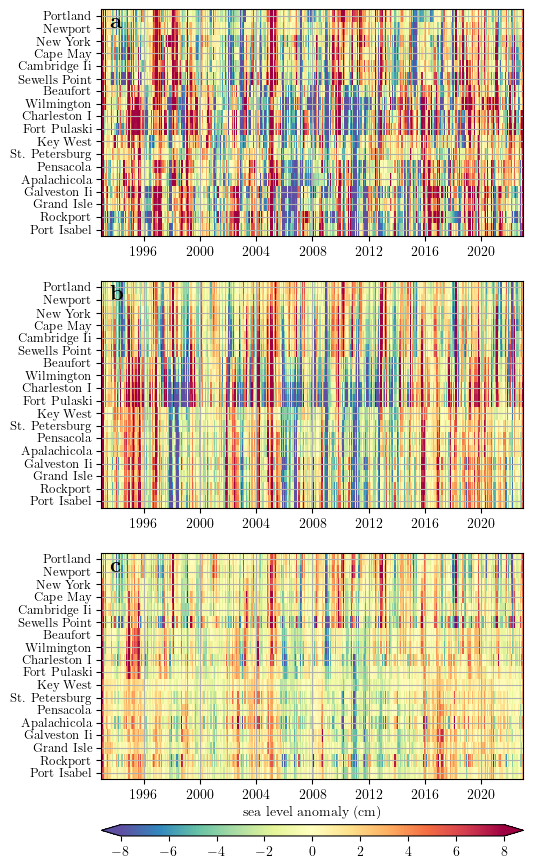

In [11]:
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in np.arange(3):
    if nsim<1:
        plotvar=xr_tg
        
    else:
        if nsim<2:
            plotvar=hr_tg
        else:
            plotvar=lr_tg

    ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        xr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    ax1.title.set_ticks(ticks, labels=labels, fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)

## EOF

[49.25888197 23.25699204 11.17934865]
[59.82637019 26.7911889   8.29318149]
[47.7312036  31.68916661  8.37923843]


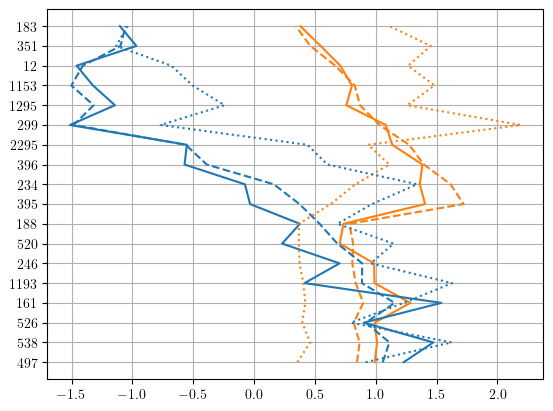

In [14]:
cuts=[12,24,48]
cutoff=cuts[2]
truncation=3

for nsens in np.arange(3):
    if nsens<1:
        lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(xr_tg, cutoff, truncation)
    else:
        if nsens<2:
            lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(hr_tg, cutoff, truncation)
        else:
            lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(lr_tg, cutoff, truncation)
    for nmode in np.arange(2):
        if eofs[nmode,0]<0:
            eofs[nmode,:]=-eofs[nmode,:]
        plt.plot(eofs[nmode,:],hr_tg.tgindex,color=cols[nmode+1],linestyle=lines[nsens])
    print(pvar[0:3])
    # print(pvar_slow)
plt.grid()
# tgftot1950_gmrem

## LF EOF

[26.85326064 41.88120266 15.74006076]
[62.22271272 22.0247702  13.20280136]
[55.75443506 11.64074251 23.68343854]


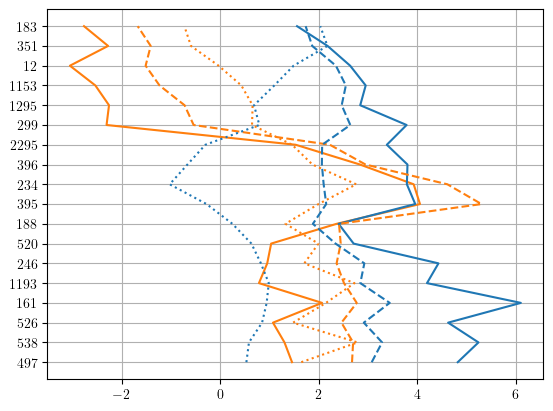

In [15]:
cutoff=cuts[1]
for nsens in np.arange(3):
    if nsens<1:
        lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(xr_tg, cutoff, truncation)
    else:
        if nsens<2:
            lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(hr_tg, cutoff, truncation)
        else:
            lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(lr_tg, cutoff, truncation)
    for nmode in np.arange(2):
        if lfps[nmode,0]<0:
            lfps[nmode,:]=-lfps[nmode,:]
        plt.plot(lfps[nmode,:],hr_tg.tgindex,color=cols[nmode+1],linestyle=lines[nsens])
    # print(pvar[0:3])
    print(pvar_slow)
plt.grid()
# tgftot1950_gmrem

[51.46140939 28.63546614 16.50459443]
[30.14921539 34.77735813 29.98416706]
[62.22271272 22.0247702  13.20280136]
[32.13628544 29.77593881 32.99851634]
[76.51110663  9.88959954 11.3112209 ]
[30.56971938 21.24852332 43.09249789]


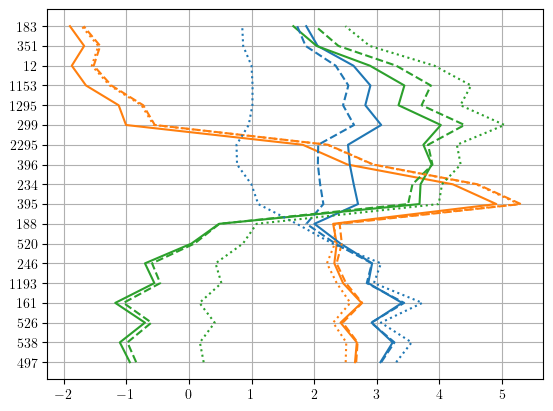

In [16]:
for nsens in np.arange(3):
    cuts=[12,24,48]
    cutoff=cuts[nsens]
    truncation=3
    lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(hr_tg, cutoff, truncation)
    for nmode in np.arange(3):
        if lfps[nmode,9]<0:
            lfps[nmode,:]=-lfps[nmode,:]
        plt.plot(lfps[nmode,:],xr_tg.tgindex,color=cols[nmode+1],linestyle=lines[nsens])
    # print(pvar)
    print(pvar_slow[0:3])
    print(pvar_lfc[0:3])
plt.grid()
# tgftot1950_gmrem

In [17]:
def butter_bpfilt_high(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='high')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_band(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1, fc2], fs=fs, btype='band')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_low(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='low')
    return signal.filtfilt(b, a, x)

def filtfilt_bpbutter_2d_band(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_band,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt
def filtfilt_bpbutter_2d_high(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_high,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt
    
def filtfilt_bpbutter_2d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt    
    
def filtfilt_bpbutter_3d_band(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_band,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["nlat","nlon","time"], [], [], [], []],  # regrid
        output_core_dims=[["nlat","nlon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt

def filtfilt_bpbutter_3d_high(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_high,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["nlat","nlon","time"], [], [], [], []],  # regrid
        output_core_dims=[["nlat","nlon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt
def filtfilt_bpbutter_3d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["nlat","nlon","time"], [], [], [], []],  # regrid
        output_core_dims=[["nlat","nlon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt

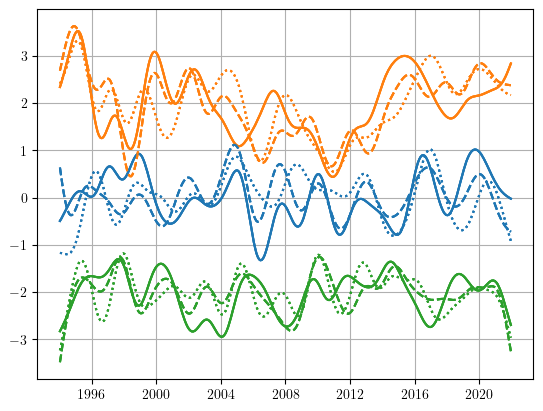

In [18]:
for nsens in np.arange(3):
    cutoff=cuts[1]
    for nsens in np.arange(3):
        if nsens<1:
            lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(xr_tg, cutoff, truncation)
        else:
            if nsens<2:
                lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(hr_tg, cutoff, truncation)
            else:
                lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(lr_tg, cutoff, truncation)
        for nmode in np.arange(3):
            if lfps[nmode,0]<0:
                lfps[nmode,:]=-lfps[nmode,:]
                lfcs[nmode,:]=-lfcs[nmode,:]
            if nmode<1:
                plt.plot(xr_tg.time[int(cutoff/2):int(-cutoff/2)],butter_bpfilt_low(lfcs[int(cutoff/2):int(-cutoff/2),0],1/24,0,1,5)+2,color=cols[0+1],linestyle=lines[nsens])
            else:
                if nmode<2:
                    plt.plot(xr_tg.time[int(cutoff/2):int(-cutoff/2)],butter_bpfilt_low(lfcs[int(cutoff/2):int(-cutoff/2),1],1/24,0,1,5),color=cols[0+2],linestyle=lines[nsens])
                else:
                    plt.plot(xr_tg.time[int(cutoff/2):int(-cutoff/2)],butter_bpfilt_low(lfcs[int(cutoff/2):int(-cutoff/2),2],1/24,0,1,5)-2,color=cols[0+3],linestyle=lines[nsens])
        # print(pvar_slow)
plt.grid()

[62.22271272 22.0247702  13.20280136]
[32.13628544 29.77593881 32.99851634]


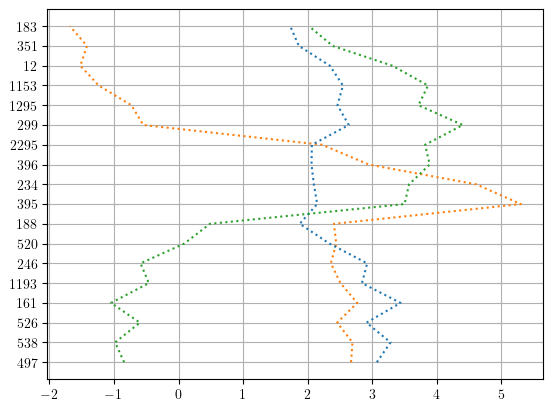

In [37]:
cutoff=cuts[1]
# lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(lr_tg, cutoff, truncation)
lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(hr_tg, cutoff, truncation)
for nmode in np.arange(3):
    if lfps[nmode,9]<0:
        lfps[nmode,:]=-lfps[nmode,:]
        lfcs[nmode,:]=-lfcs[nmode,:]
    plt.plot(lfps[nmode,:],xr_tg.tgindex,color=cols[nmode+1],linestyle=lines[nsens])
# print(pvar)
print(pvar_slow[0:3])
print(pvar_lfc[0:3])
plt.grid()
# tgftot1950_gmrem

In [20]:
## can look at FOSI, but then note that each mode is under or over expressed, 
# or has a different structure, to identify biases.

In [36]:
for nmode in np.arange(3):
    lfcs[:,nmode]=butter_bpfilt_low(lfcs[:,nmode],1/cutoff,0,1,5)
lfcs=lfcs[int(cutoff/2):int(-cutoff/2),:]

In [40]:
def plot_ssh_reg(tgpcs,SSH,tglons,tglats):
    fig = plt.figure(figsize=(12,6), tight_layout=True)
    vmin=-6
    vmax=-vmin
    
    cmap = mycolors.blue2red_cmap(20)
    
    for nsp in np.arange(3):
        for nsim in np.arange(1):
            lagx=0
            lons=tglons
            lats=tglats 
            tgpcs=tgpcs
            regressand=SSH 
            # regressand2=xr_tg.TG_IB_CORR
                    
            focusts=regressand[:,0,0].fillna(0)*0+np.real(tgpcs[nsp,:])
            cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=focusts,y=regressand, lagx=lagx)
            altrc=slope+regressand[0,:,:]*0
            altpval=pval
            mask=1+0/(pval<pvalc)
            # focusts=regressand2.isel(tgindex=0).squeeze()*0+np.real(tgpcs[nsp,:])
            # cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=focusts,y=regressand2, lagx=lagx)
            
            ax = plt.subplot2grid((1,3), (0, nsp), colspan=1, rowspan=1, projection=xccrs.PlateCarree())#, aspect="auto")
            
            pos = ax.get_position() # get the original position 
            ax.set_extent([-100, -60, 20, 52], crs=xccrs.PlateCarree())
            # ax.set_extent([-100, 0, 10, 70], crs=xccrs.PlateCarree())
            im = ax.pcolormesh(lons, lats, mask*altrc, shading='nearest', vmin=vmin, vmax=vmax, 
            # im = ax.pcolormesh(lons, lats, altrc, shading='nearest', vmin=vmin, vmax=vmax, 
                        cmap=cmap,zorder=1,transform=xccrs.PlateCarree())    

            CS2 = ax.contour(ds_bathy.depth.longitude ,ds_bathy.depth.latitude, -ds_bathy.depth,
                            np.arange(100,101,1),colors='.6',linewidths=2,zorder=2,transform=xccrs.PlateCarree())
            
            CS2 = ax.contour(ds_bathy.depth.longitude ,ds_bathy.depth.latitude, -ds_bathy.depth,
                           np.arange(1000,2000,1000),colors='.6',linewidths=1,zorder=2,transform=xccrs.PlateCarree())

            if nsp==0:
                cbar_ax = fig.add_axes(
                    [pos.x1-(pos.x1 - pos.x0)/10, pos.y0+(pos.y1 - pos.y0)/10, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
                )
                cbar = fig.colorbar(im, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
                # cbar.ax.set_title("Reg. Coef. on PC" + str(nmode+1), rotation=0, size=10, weight="bold")
                cbar.ax.tick_params(labelsize=10)
                
            # if nsim<1:
            #     plt.figtext(.05, .95, 'Regression on HR PC'+str(nsp+1), horizontalalignment='left', verticalalignment='center', fontsize=20, transform=ax.transAxes)
            # else:
            #     plt.figtext(.05, .95, 'Regression on LR PC'+str(nsp+1), horizontalalignment='left', verticalalignment='center', fontsize=20, transform=ax.transAxes)
                            
            ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
            # ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
    
            ax.coastlines(zorder=5)
            ax.gridlines()
            # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
    # return altrc

## Regression of full simulation modes on unfiltered SSH

In [35]:
pvalc=.05

ds_bathy = xr.open_dataset('/glade/work/clittle/p2521/input/'+"/obs/GEBCO.nc")
# ds_bathy.depth

In [28]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_det.nc')
da=ssh.ssh#.isel(time=slice(edgevals,-edgevals))
##bandpass

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


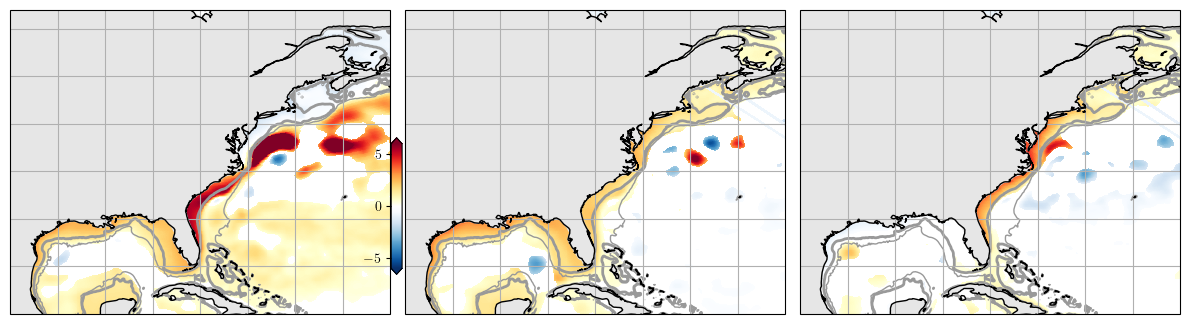

In [29]:
#detrend unfiltered
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


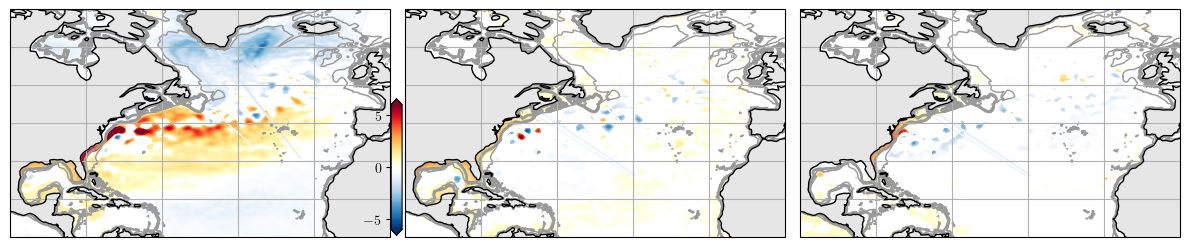

In [31]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [73]:
# S Hatteras has STG involvement and evidence for NW shift in GS
# Mode 2 and 3 shelf-focused

## Regression of full simulation modes on low pass filtered SSH

In [37]:
dain=filtfilt_bpbutter_3d_low(da.load(),1/24,0*1/3,1,5,dim='time')
dain=dain.transpose('time', 'nlat', 'nlon')
dain=dain[int(cutoff/2):int(-cutoff/2),:,:]

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


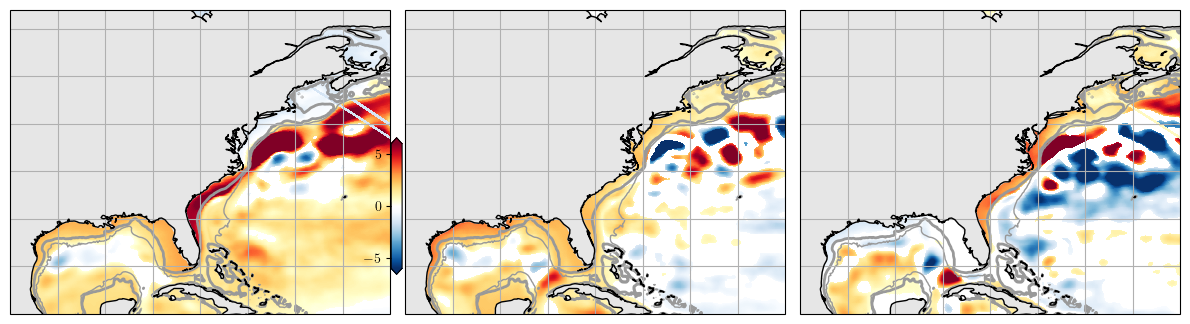

In [56]:
#detrend filtered
inc=1
plot_ssh_reg(lfcs.T,dain,dain.TLONG.fillna(0),dain.TLAT.fillna(0))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


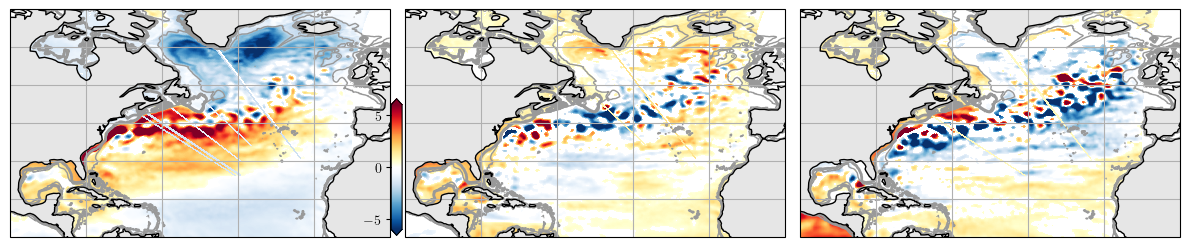

In [58]:
#detrend filtered
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,dain,dain.TLONG.fillna(0),dain.TLAT.fillna(0))

## Regression of full simulation modes on M/B SSH

In [31]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_m-r_det.nc')
da=ssh.ssh#.isel(time=slice(edgevals,-edgevals))
##bandpass

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


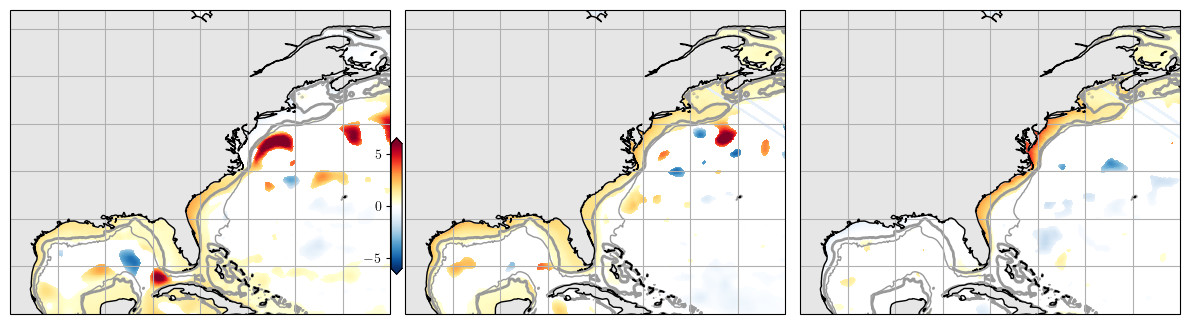

In [66]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


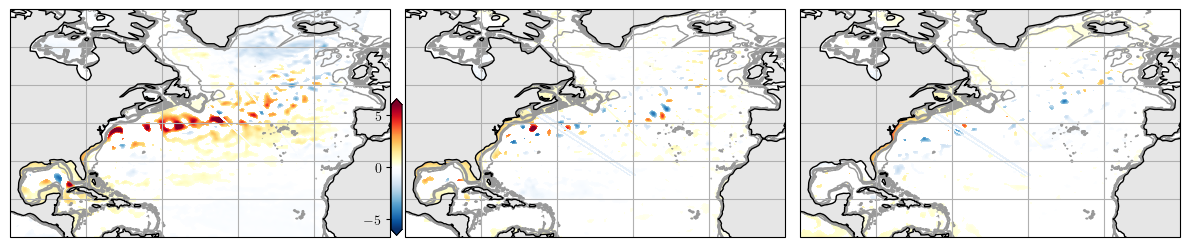

In [64]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [74]:
# momentum forcing drives mode 1 GS shift (local or remote forced?)
# East west dipole in SPG (wind forced signature of NAO)
# all modes are mostly momentum forced 

In [38]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_b_det.nc')
da=ssh.ssh#.isel(time=slice(edgevals,-edgevals))
##bandpass

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


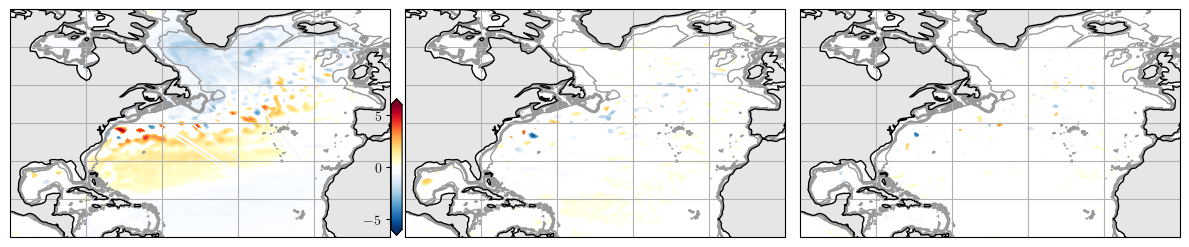

In [39]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


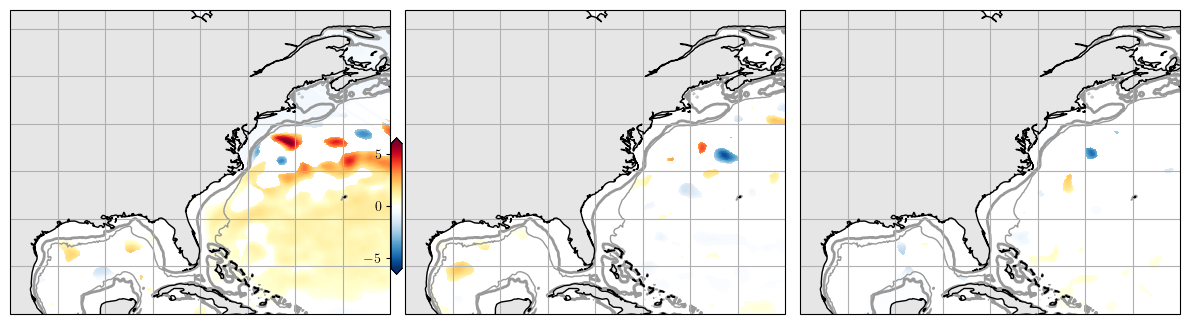

In [41]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [77]:
## NAO tripole assocaited with buoyancy forcings
# mode 1 buoyancy forcing drives dipole but of limited amplitude at the coast
# buoyancy forcing and sea level at basin scale is assocaited but is not the driver of coastal variability!
# mode 2 has almost no buoyancy forced component

In [ ]:
# interior buoyancy forced mode has a relatatively weak expression 
# Mode 1 would be uniform except for compensating conincident buoyancy-forced 
# Mode 2 has limited buoyancy involvement 

In [47]:
## need to reconcile with ECCO studies! Coastal representation important!!

## M/B modes

/glade/derecho/scratch/clittle/tmp/ipykernel_4669/1281829375.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_4669/1281829375.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((4,3), (nsim, 1), colspan=2, rowspan=1)
/glade/derecho/scratch/clittle/tmp/ipykernel_4669/1281829375.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0,

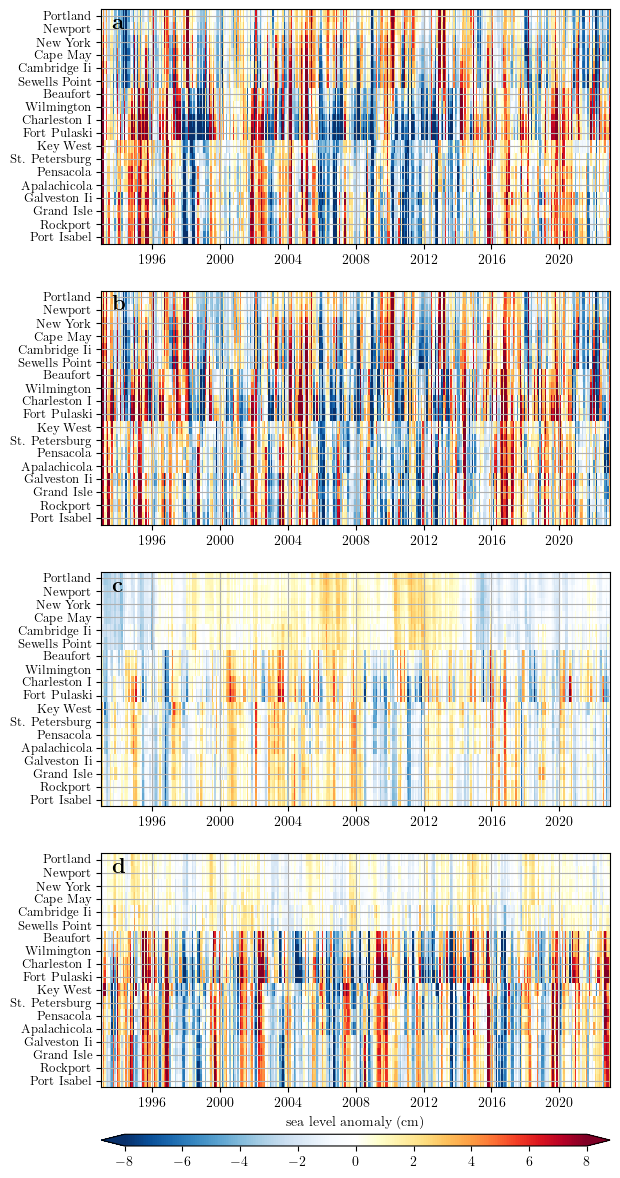

In [19]:
fig = plt.figure(figsize=(10,14))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in np.arange(4):
    if nsim<1:
        plotvar=hr_tg
    else:
        if nsim<2:
            plotvar=hr_m_tg
        else:
            if nsim<3:
                plotvar=hr_b_tg
            else:
                plotvar=hr_tg-hr_m_tg-hr_b_tg
    ax1 = plt.subplot2grid((4,3), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        xr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)
plt.savefig('USEC_M_B_timeseries.png',
)

In [30]:
#REPEAT TG/HR/LR analysis for FULL/B/M once we clean up LFCAs

In [ ]:
##LR

In [77]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_det.nc')
da=ssh.ssh#.isel(time=slice(edgevals,-edgevals))
##bandpass

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


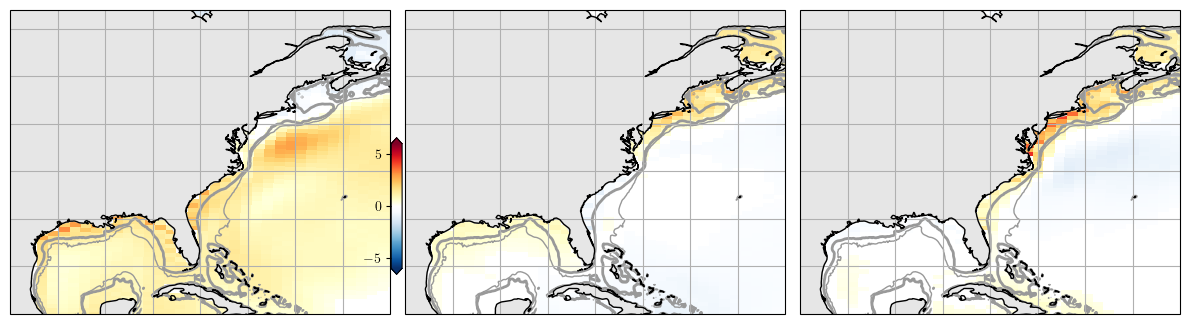

In [80]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [81]:
## LRs biggest difference is Mode 2, where south of hatteras coastal path is not permitted. others look similar

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


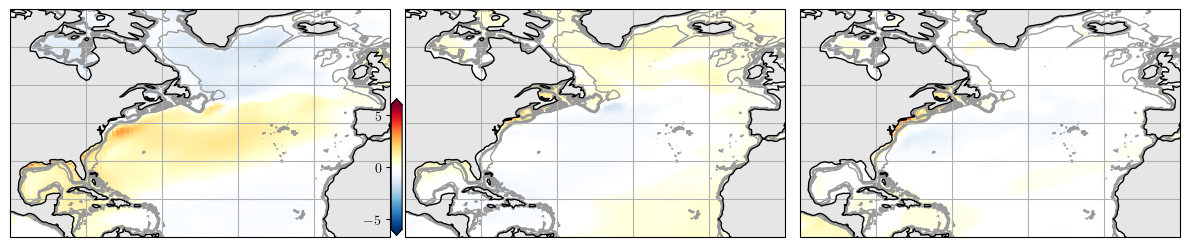

In [78]:
#detrend unfiltered
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [82]:
dain=filtfilt_bpbutter_3d_low(da.load(),1/24,0*1/3,1,5,dim='time')
dain=dain.transpose('time', 'nlat', 'nlon')
dain=dain[int(cutoff/2):int(-cutoff/2),:,:]

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


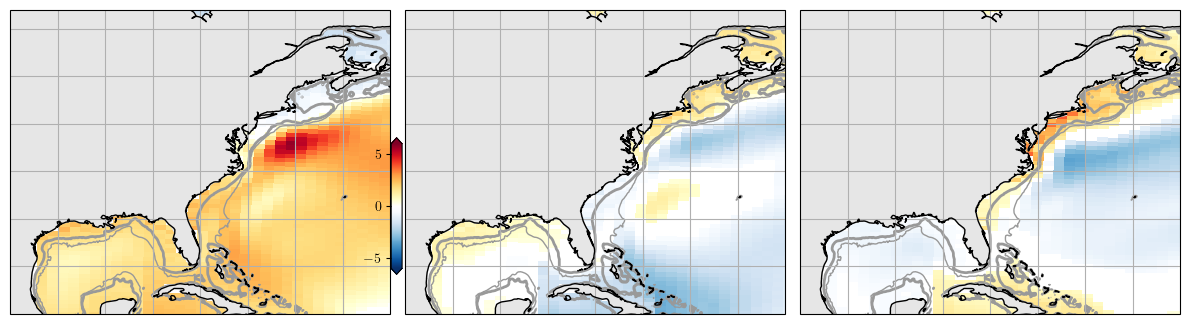

In [85]:
#detrend filtered
inc=1
plot_ssh_reg(lfcs.T,dain,dain.TLONG.fillna(0),dain.TLAT.fillna(0))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


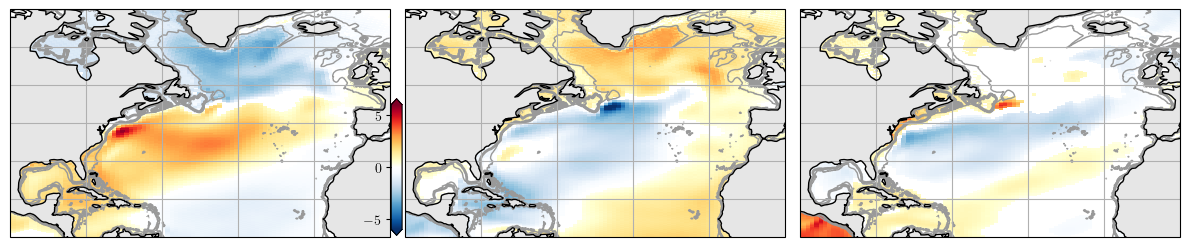

In [87]:
#detrend filtered
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,dain,dain.TLONG.fillna(0),dain.TLAT.fillna(0))

## comp with FOSIS

In [24]:
kwargs = dict(n_modes=len(xr_tg.T)-1,random_state=2)#, normalize=True)
expvars=[]
pcs=[]
amps=[]
phases=[]
recs_m1=[]
recs_m2=[]
recs_m3=[]
recs_tot=[]
real_ts=[]
djf_flag=True
djf_flag=False

for nsim in np.arange(3):
    if nsim<1:
        dain=xr_tg
    else:
        if nsim<2:
            dain=hr_tg.T
        else:
            dain=lr_tg.T
            
    if djf_flag:
        dain=djf_mean(dain)
    
    # model = xeofs.models.ComplexEOF(padding="none", **kwargs)
    # model = xeofs.models.EOF(**kwargs)
    model = xeofs.single.EOF(**kwargs)
    model.fit(dain, dim=("time"))
    expvar = model.explained_variance()
    expvar_ratio = model.explained_variance_ratio()
    amp = model.components()
    phase = amp
    # amp = model.components_amplitude()
    # phase = model.components_phase()
    phase = phase-phase.sel(tgindex='351')
    scores = model.scores(normalized=True)
    
    expvars.append(expvar_ratio)
    real_ts.append(dain)
    pcs.append(scores)
    amps.append(amp)
    phases.append(phase)
    
    rec=model.inverse_transform(scores[0,:],normalized=True)
    recs_m1.append(rec)
    rec=model.inverse_transform(scores[1,:],normalized=True)
    recs_m2.append(rec)
    rec=model.inverse_transform(scores[2,:],normalized=True)
    recs_m3.append(rec)
    rec=model.inverse_transform(scores,normalized=True)
    recs_tot.append(rec)
    if nsim<1:
        tgout=dain

In [25]:
for nsim in np.arange(len(pcs)): 
    # total_var=real_ts[nsim].var(dim='time')
    norm_fac=np.real(pcs[nsim]).std(dim='time')
    pcs[nsim]=np.real(pcs[nsim])/norm_fac
    amps[nsim]=np.real(amps[nsim])/norm_fac

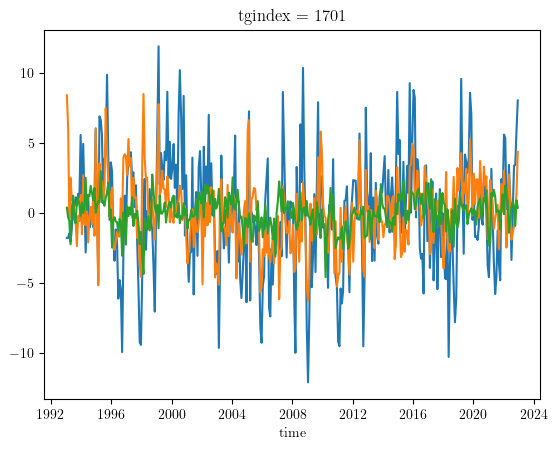

In [26]:
ntg=1
nsim=0
# recs_m1[0][:,4].plot()
# recs_m2[0][:,4].plot()
# recs_m3=recs_m1+recs_m2
real_ts[nsim][:,ntg].plot()
recs_m1[nsim][:,ntg].plot()
# recs_m2[nsim][:,ntg].plot()
recs_m2[nsim][:,ntg].plot()
# recs_tot[nsim][:,ntg].plot()
# (recs_m1[nsim][:,ntg]+recs_m2[nsim][:,ntg]+recs_m3[nsim][:,ntg]).plot()

In [27]:
expvars[0].values,expvars[1].values#,expvars[2].values

(array([0.50212646, 0.21566909, 0.10917858, 0.04631361, 0.0396237 ,
        0.01976455, 0.01267414, 0.01129293, 0.00873961, 0.00791226,
        0.0052353 , 0.00459787, 0.0041559 , 0.00351604, 0.00271477,
        0.00226006, 0.0015741 , 0.00156129]),
 array([6.11387060e-01, 2.57955118e-01, 7.59165269e-02, 2.43648021e-02,
        9.56903295e-03, 9.40672270e-03, 3.40372998e-03, 1.96957163e-03,
        1.54463671e-03, 1.22471023e-03, 8.76642417e-04, 7.74235874e-04,
        5.09240439e-04, 2.70653469e-04, 2.49652422e-04, 2.18247014e-04,
        1.56438263e-04, 1.10080205e-04]))

In [28]:
def plot_fosi_pcs(tgpcs,amps,recs_mode,nmode,vmaxin,varscale):
    fig = plt.figure(figsize=(10,8), tight_layout=True)
    cmap = mycolors.blue2red_cmap(20)
    
    for nsim in np.arange(3):
        ax = plt.subplot2grid((3,3), (0, nsim), colspan=1, rowspan=2, projection=rotated_crs, aspect="auto")
        pos = ax.get_position() # get the original position 
        vmax=vmaxin
        vmin=-vmax
        
        tot_var=recs_tot[nsim].var(dim='time')    
        VE=recs_mode[nsim].std(dim='time')
        
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=amps[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            s=varscale*VE,
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        for nkey in np.arange(2):
            varval=varscale*(.25+.5*nkey)**2
            
            varkey = plt.scatter(
                x=tgs_in.lon,
                y=tgs_in.lat,
                vmin=vmin,
                vmax=vmax,
                c=amps[nsim][nmode,:],
                cmap=cmap,  # this is the changes
                s=varval,
                alpha=1,
                edgecolors=".6",
                linewidth=1,
                # marker=None,
                zorder=7,
                transform=xccrs.PlateCarree(),
            )  ## Important
            
            varkey.set_facecolor("none")   
            
        ax.set_extent([-74, -78, 20, 48], crs=xccrs.PlateCarree())       
        ax.set_extent([-90, -78, 21, 47], crs=xccrs.PlateCarree())       
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nsim<1:
            cbar_ax = fig.add_axes(
                [pos.x1-(pos.x1 - pos.x0)/3.5, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/1.75]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF amplitude", rotation=0, size=12, weight="bold")
            cbar.ax.tick_params(labelsize=10)
        if nsim<1:    
            plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
            plt.figtext(0.02, .1, 'Tide Gauge', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
        else:
            if nsim<2:    
                plt.figtext(0.02, .1, 'HR', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
            else:
                plt.figtext(0.02, .1, 'LR', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvars[nsim][nmode].values*100)+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
# ax1.text(.02,.92, r"$\bf{" + panellabs[0] + "}$", transform=ax1.transAxes, fontsize=18, weight='bold')
        
    ax = plt.subplot2grid((3,3), (2,0), colspan=3, rowspan=1)    
    for nsim in np.arange(3):
        line = ax.plot(xr_tg.time,tgpcs[nsim][nmode,:],cols[nsim], label = 'data')
        if nsim>0:
            tt=np.corrcoef(tgpcs[nsim][nmode,:],tgpcs[0][nmode,:])
            if nsim<2:
                ax.text(.25,.83, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C1')
            else:
                ax.text(.25,.73, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C0') 
    plt.ylim(-5,5)
    plt.grid()
    plt.ylabel('Normalized PC1',fontsize=12)
    ax.legend([],     # The line objects
           labels=["Tide Gauge", "HR", "LR"],   # The labels for each line
           loc="lower left",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
           )

In [29]:
def plot_fosi_pcs_m2(tgpcs,amps,recs_mode,nmode,vmaxin,varscale):
    fig = plt.figure(figsize=(10,8), tight_layout=True)
    cmap = mycolors.blue2red_cmap(20)
    
    for nsim in np.arange(3):
        ax = plt.subplot2grid((3,3), (0, nsim), colspan=1, rowspan=2, projection=rotated_crs, aspect="auto")
        pos = ax.get_position() # get the original position 
        vmax=vmaxin
        vmin=-vmax
        
        tot_var=recs_tot[nsim].var(dim='time')    
        VE=recs_mode[nsim].std(dim='time')

        if nsim==2:
            factor=-1
        else:
            factor=1
            
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=factor*amps[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            s=varscale*VE,
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        for nkey in np.arange(2):
            varval=varscale*(.25+.5*nkey)**2
            
            varkey = plt.scatter(
                x=tgs_in.lon,
                y=tgs_in.lat,
                vmin=vmin,
                vmax=vmax,
                c=factor*amps[nsim][nmode,:],
                cmap=cmap,  # this is the changes
                s=varval,
                alpha=1,
                edgecolors=".6",
                linewidth=1,
                # marker=None,
                zorder=7,
                transform=xccrs.PlateCarree(),
            )  ## Important
            
            varkey.set_facecolor("none")   
            
        ax.set_extent([-90, -78, 21, 47], crs=xccrs.PlateCarree())       
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nsim<1:
            cbar_ax = fig.add_axes(
                [pos.x1-(pos.x1 - pos.x0)/3.5, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/1.75]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF amplitude", rotation=0, size=12, weight="bold")
            cbar.ax.tick_params(labelsize=10)
        if nsim<1:    
            plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
            plt.figtext(0.02, .1, 'Tide Gauge', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
        else:
            if nsim<2:    
                plt.figtext(0.02, .1, 'HR', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
            else:
                plt.figtext(0.02, .1, 'LR', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvars[nsim][nmode].values*100)+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
# ax1.text(.02,.92, r"$\bf{" + panellabs[0] + "}$", transform=ax1.transAxes, fontsize=18, weight='bold')
        
    ax = plt.subplot2grid((3,3), (2,0), colspan=3, rowspan=1)    
    for nsim in np.arange(3):
        if nsim==2:
            factor=-1
        else:
            factor=1
        
        line = ax.plot(xr_tg.time,factor*tgpcs[nsim][nmode,:],cols[nsim], label = 'data')
        if nsim>0:
            tt=factor*np.corrcoef(tgpcs[nsim][nmode,:],tgpcs[0][nmode,:])
            if nsim<2:
                ax.text(.25,.83, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C1')
            else:
                ax.text(.25,.73, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C0') 
    plt.ylim(-5,5)
    plt.grid()
    plt.ylabel('Normalized PC1',fontsize=12)
    ax.legend([],     # The line objects
           labels=["Tide Gauge", "HR", "LR"],   # The labels for each line
           loc="lower left",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
           )

In [30]:
def plot_fosi_pcs_m3(tgpcs,amps,recs_mode,nmode,vmaxin,varscale):
    fig = plt.figure(figsize=(10,8), tight_layout=True)
    cmap = mycolors.blue2red_cmap(20)
    
    for nsim in np.arange(3):
        ax = plt.subplot2grid((3,3), (0, nsim), colspan=1, rowspan=2, projection=rotated_crs, aspect="auto")
        pos = ax.get_position() # get the original position 
        vmax=vmaxin
        vmin=-vmax
        
        tot_var=recs_tot[nsim].var(dim='time')    
        VE=recs_mode[nsim].std(dim='time')

        if nsim==2:
            factor=-1
        else:
            factor=1
            
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=factor*amps[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            s=varscale*VE,
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        for nkey in np.arange(2):
            varval=varscale*(.25+.5*nkey)**2
            
            varkey = plt.scatter(
                x=tgs_in.lon,
                y=tgs_in.lat,
                vmin=vmin,
                vmax=vmax,
                c=factor*amps[nsim][nmode,:],
                cmap=cmap,  # this is the changes
                s=varval,
                alpha=1,
                edgecolors=".6",
                linewidth=1,
                # marker=None,
                zorder=7,
                transform=xccrs.PlateCarree(),
            )  ## Important
            
            varkey.set_facecolor("none")   
            
        ax.set_extent([-90, -78, 21, 47], crs=xccrs.PlateCarree())       
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nsim<1:
            cbar_ax = fig.add_axes(
                [pos.x1-(pos.x1 - pos.x0)/3.5, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/1.75]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF amplitude", rotation=0, size=12, weight="bold")
            cbar.ax.tick_params(labelsize=10)
        if nsim<1:    
            plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
            plt.figtext(0.02, .1, 'Tide Gauge', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
        else:
            if nsim<2:    
                plt.figtext(0.02, .1, 'HR', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
            else:
                plt.figtext(0.02, .1, 'LR', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvars[nsim][nmode].values*100)+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
# ax1.text(.02,.92, r"$\bf{" + panellabs[0] + "}$", transform=ax1.transAxes, fontsize=18, weight='bold')
        
    ax = plt.subplot2grid((3,3), (2,0), colspan=3, rowspan=1)    
    for nsim in np.arange(1):
        if nsim==2:
            factor=-1
        else:
            factor=1
        
        line = ax.plot(xr_tg.time,factor*tgpcs[nsim][nmode,:],cols[nsim], label = 'data')
        if nsim>0:
            tt=factor*np.corrcoef(tgpcs[nsim][nmode,:],tgpcs[0][nmode,:])
            if nsim<2:
                ax.text(.25,.83, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C1')
            else:
                ax.text(.25,.73, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C0') 
    plt.ylim(-5,5)
    plt.grid()
    plt.ylabel('Normalized PC1',fontsize=12)
    ax.legend([],     # The line objects
           labels=["Tide Gauge", "HR", "LR"],   # The labels for each line
           loc="lower left",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
           )

In [31]:
rotated_crs = xccrs.RotatedPole(pole_longitude=25.0, pole_latitude=70.0) # define projection!
varscale=20
vmaxin=7

/glade/derecho/scratch/clittle/tmp/ipykernel_22189/233526093.py:96: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


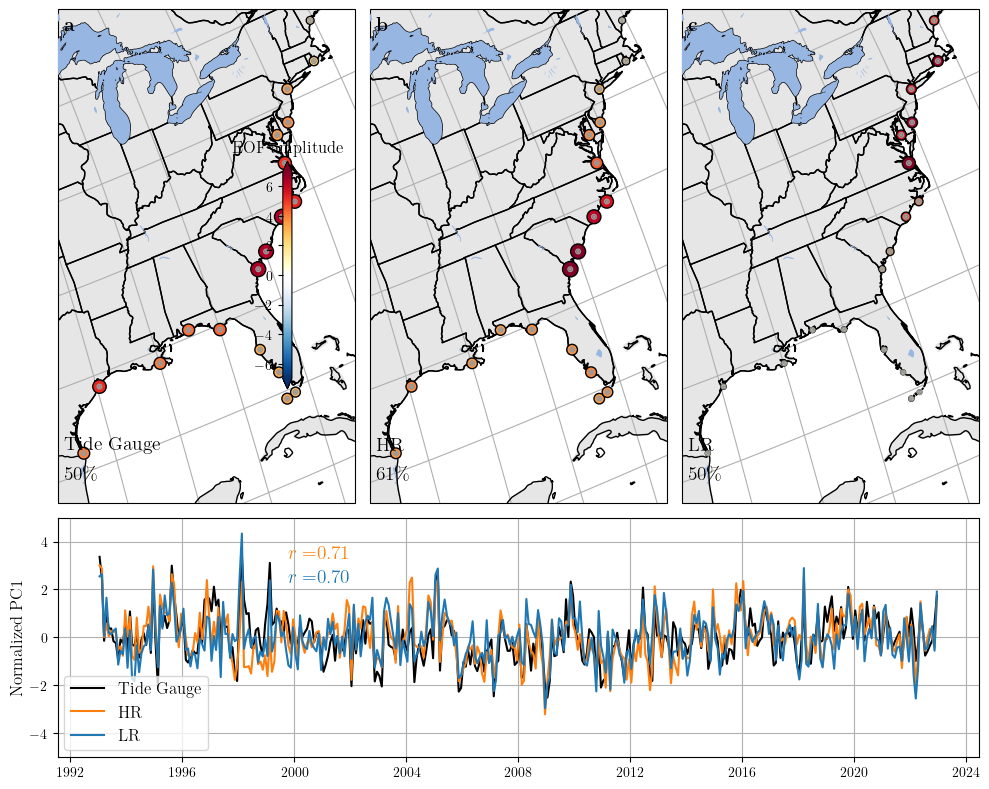

In [32]:
plot_fosi_pcs(pcs,amps,recs_m1,0,vmaxin,varscale)
# plt.savefig('f1.png',
# )

/glade/derecho/scratch/clittle/tmp/ipykernel_22189/21382045.py:105: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


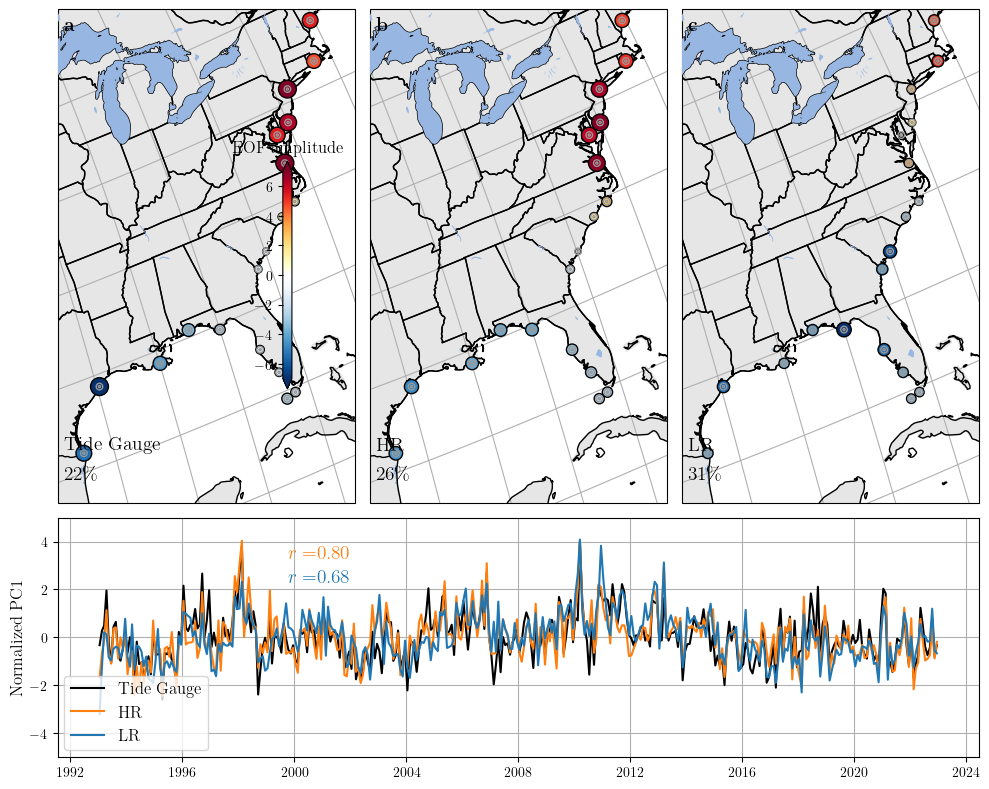

In [33]:
varscale=40
plot_fosi_pcs_m2(pcs,amps,recs_m2,1,vmaxin,varscale)
# plt.savefig('s3.png',
# )
varscale=300

/glade/derecho/scratch/clittle/tmp/ipykernel_22189/799633487.py:105: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


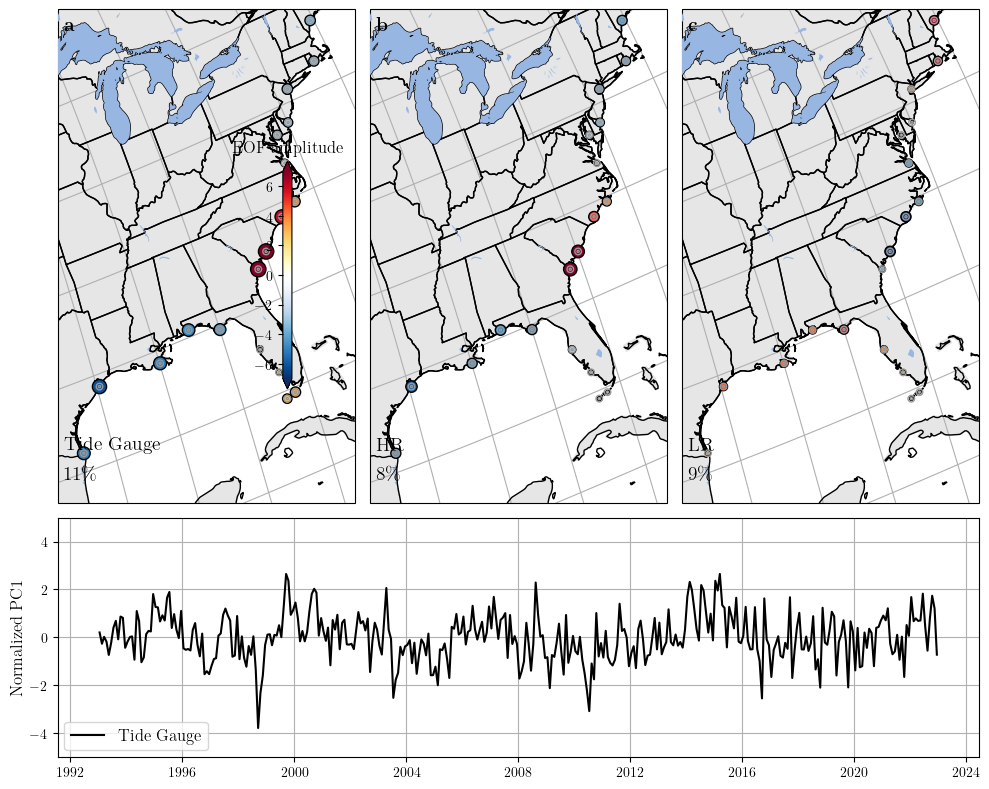

In [34]:
varscale=40
plot_fosi_pcs_m3(pcs,amps,recs_m3,2,vmaxin,varscale)
# plt.savefig('s3.png',
# )
varscale=300

In [20]:
## does removing do anything different.
##try LFCA?

/glade/derecho/scratch/clittle/tmp/ipykernel_22189/2381225653.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_22189/2381225653.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_22189/2381225653.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

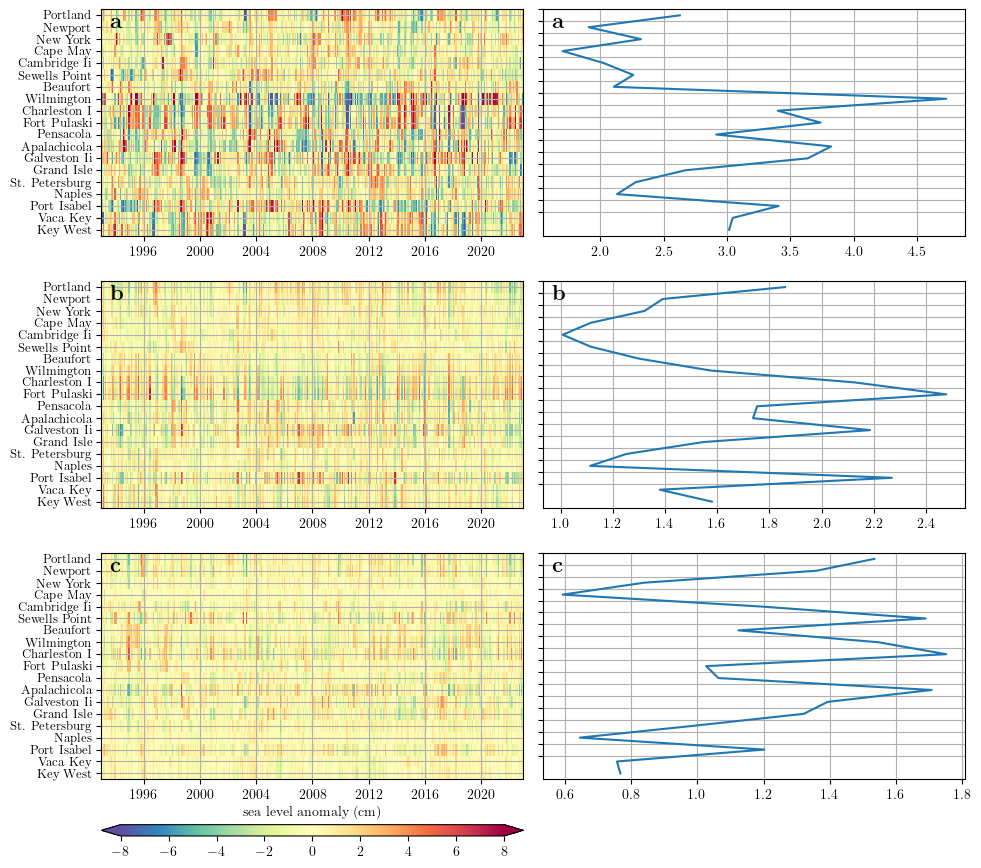

In [35]:
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin
dain_obs=xr_tg

for nsim in np.arange(3):
    if nsim<1:
        plotvar=xr_tg-recs_m1[0]-recs_m2[0]
    else:
        if nsim<2:
            plotvar=hr_tg.T-recs_m1[1]-recs_m2[1]
        else:
            plotvar=lr_tg.T-recs_m1[2]-recs_m2[2]

    ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        xr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)

    ax1 = plt.subplot2grid((3,5), (nsim, 3), colspan=2, rowspan=1)

    ax1.plot(
        plotvar.std(dim='time'),
        np.arange(0, len(tgnames), 1),
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
    labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
    ax1.yaxis.set_ticks(ticks, labels=[], fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    # pos = ax1.get_position()  # get the original position
    
    # if nsim>1:
    #     cbar_ax = fig.add_axes(
    #         [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
    #     )
    #     cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
    #     cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
    #     cbar.ax.tick_params(labelsize=10)

/glade/derecho/scratch/clittle/tmp/ipykernel_22189/1293883833.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.loglog((1/(12*f)),Pxx_den,cols[0], label = 'data')
/glade/derecho/scratch/clittle/tmp/ipykernel_22189/1293883833.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.loglog((1/(12*f)),spec99/np.sum(rspec),cols[0],'--', label = '99% confidence', ls='--')
/glade/derecho/scratch/clittle/tmp/ipykernel_22189/1293883833.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.loglog((1/(12*f)),Pxx_den,cols[1], label = 'data')
/glade/derecho/scratch/clittle/tmp/ipykernel_22189/1293883833.py:12: RuntimeWarning: divide by zero encountered in divide
  plt.loglog((1/(12*f)),Pxx_den,cols[1], label = 'data')
/glade/derecho/scratch/clittle/tmp/ipykernel_22189/1293883833.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,10])


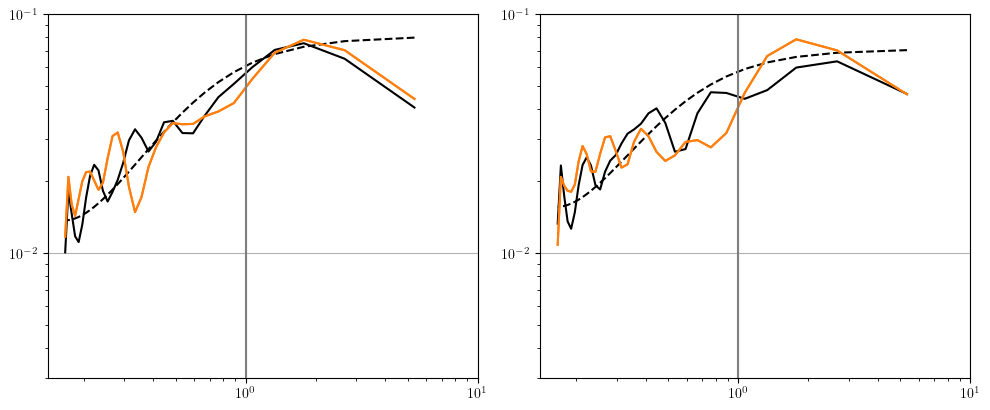

In [36]:
fig = plt.figure(figsize=(10,8), tight_layout=True)
    
for nsim in np.arange(2):
    ax = plt.subplot2grid((2,2), (0, nsim), colspan=1, rowspan=1)
    # [Pxx_den,f,freq,rspec,spec99]=calc_power(pcs[nsim][2,:])
    # plt.plot((1/(12*f)),Pxx_den,cols[2], label = 'data')
    [Pxx_den,f,freq,rspec,spec99]=calc_power(pcs[nsim][0,:])
    plt.loglog((1/(12*f)),Pxx_den,cols[0], label = 'data')
    plt.loglog((1/(12*f)),spec99/np.sum(rspec),cols[0],'--', label = '99% confidence', ls='--')
    [Pxx_den,f,freq,rspec,spec99]=calc_power(pcs[nsim][1,:])
    plt.loglog((1/(12*f)),Pxx_den,cols[1], label = 'data')
    plt.loglog((1/(12*f)),Pxx_den,cols[1], label = 'data')
    plt.loglog()
    plt.plot([(1),(1)],[0,.1],'.5')
    plt.xlim([0,10])
    plt.ylim([3e-3,1e-1])
    plt.grid()

In [23]:
# too much of mode 1 is present at lower frequencies: why? -> gulf stream impacts mid atlantic?
# 1. What is mode 2 (Gulf/NE conncetion)
# 2. Why too much of mode 1 (opposing buoyancy/momentum forcing on shelf)

## Filter PCs

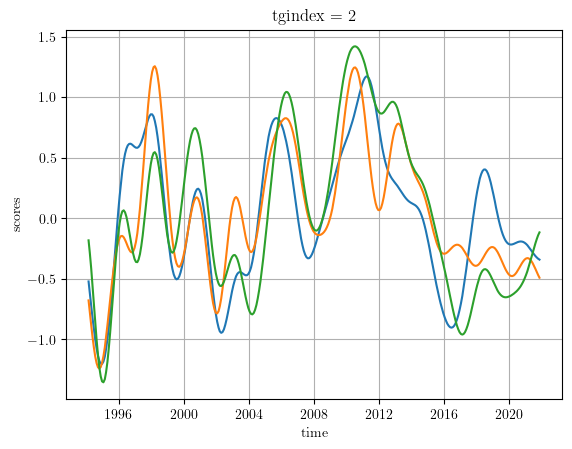

In [108]:
cutoff=12
fs=1
order=5
edgevals=int(np.ceil(cutoff/2))# dain=resid

dain=filtfilt_bpbutter_2d_low(pcs[0].rename({'mode':'tgindex'}),1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain1=dain.isel(time=slice(edgevals,-edgevals))
dain=filtfilt_bpbutter_2d_low(pcs[1].rename({'mode':'tgindex'}),1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain2=dain.isel(time=slice(edgevals,-edgevals))
dain=filtfilt_bpbutter_2d_low(pcs[2].rename({'mode':'tgindex'}),1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain3=-dain.isel(time=slice(edgevals,-edgevals))
dain1[:,1].plot()
dain2[:,1].plot()
# (dain2[:,1]-dain1[:,1]).plot()
plt.grid()
dain3[:,1].plot()

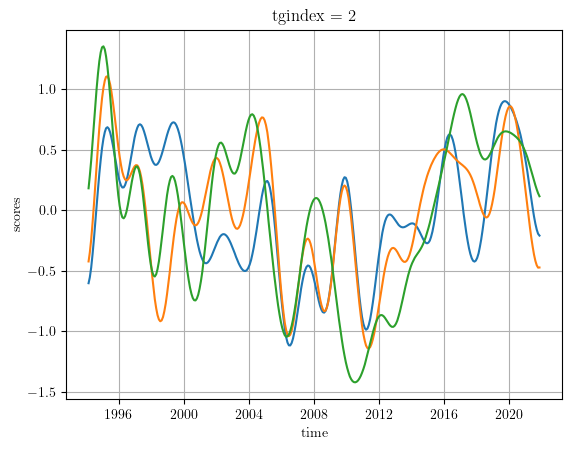

In [110]:
cutoff=25
fs=1
order=5
edgevals=int(np.ceil(cutoff/2))# dain=resid

dain=filtfilt_bpbutter_2d_low(pcs[0].rename({'mode':'tgindex'}),1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain1=dain.isel(time=slice(edgevals,-edgevals))
dain=filtfilt_bpbutter_2d_low(pcs[1].rename({'mode':'tgindex'}),1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain2=dain.isel(time=slice(edgevals,-edgevals))
dain=filtfilt_bpbutter_2d_low(pcs[2].rename({'mode':'tgindex'}),1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain3=dain.isel(time=slice(edgevals,-edgevals))
dain1[:,0].plot()
dain2[:,0].plot()
# (dain2[:,0]-dain1[:,0]).plot()
plt.grid()
dain3[:,1].plot()

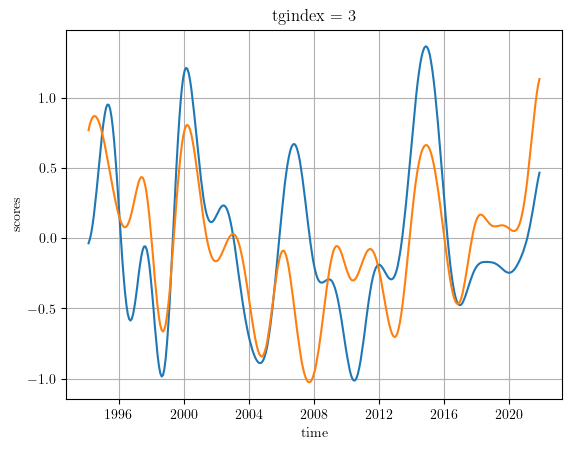

In [113]:
cutoff=25
fs=1
order=5
edgevals=int(np.ceil(cutoff/2))# dain=resid

dain=filtfilt_bpbutter_2d_low(pcs[0].rename({'mode':'tgindex'}),1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain1=dain.isel(time=slice(edgevals,-edgevals))
dain=filtfilt_bpbutter_2d_low(pcs[1].rename({'mode':'tgindex'}),1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain2=dain.isel(time=slice(edgevals,-edgevals))
dain=filtfilt_bpbutter_2d_low(pcs[2].rename({'mode':'tgindex'}),1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain3=dain.isel(time=slice(edgevals,-edgevals))
dain1[:,2].plot()
dain2[:,2].plot()
# (dain2[:,0]-dain1[:,0]).plot()
plt.grid()
# dain3[:,2].plot()

In [ ]:
#biggest issue is a single event 98-2002 -- low frequency anomaly that wasn't there.

## Filter timeseries

In [37]:
cutoff=19
fs=1
order=5
edgevals=int(np.ceil(cutoff/2))# dain=resid


xr_tg=xr.open_dataset('/glade/work/clittle/p2679/tgs_usec_93_22.nc') 
xr_tg=xr_tg.TG_IB_CORR

dain=filtfilt_bpbutter_2d_low(xr_tg,1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain1=dain.isel(time=slice(edgevals,-edgevals))
resid1=xr_tg-dain

hr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs.nc')
hr_tg=hr_tg.ssh
hr_tg['time']=xr_tg.time

dain=filtfilt_bpbutter_2d_low(hr_tg,1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain2=dain.isel(time=slice(edgevals,-edgevals))
resid2=hr_tg-dain

# dain=filtfilt_bpbutter_2d_low(lr_tg,1/cutoff,0*1/3,fs,order,dim='time')
# dain=dain.transpose('time', 'tgindex').load()
# dain3=dain.isel(time=slice(edgevals,-edgevals))
# resid3=lr_tg-dain

hr_tg_m=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_m-r_tgs.nc')
# hr_tg_r=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_r_tgs.nc')
hr_tg_b=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_b_tgs.nc')
hr_tg_m=hr_tg_m.ssh#-hr_tg_r
hr_tg_m['time']=xr_tg.time
hr_tg_b=hr_tg_b.ssh
hr_tg_b['time']=xr_tg.time

dain=filtfilt_bpbutter_2d_low(hr_tg_m,1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain4=dain.isel(time=slice(edgevals,-edgevals))
resid4=hr_tg_m-dain

dain=filtfilt_bpbutter_2d_low(hr_tg_b,1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
dain5=dain.isel(time=slice(edgevals,-edgevals))
resid5=hr_tg_b-dain

xr_tg=xr_tg.isel(time=slice(edgevals,-edgevals))
hr_tg=hr_tg.isel(time=slice(edgevals,-edgevals))
hr_tg_b=hr_tg_b.isel(time=slice(edgevals,-edgevals))
hr_tg_m=hr_tg_m.isel(time=slice(edgevals,-edgevals))
# lr_tg=hr_tg.isel(time=slice(edgevals,-edgevals))

In [38]:
# resid1=resid2.isel(time=slice(edgevals,-edgevals))
# resid2=resid4.isel(time=slice(edgevals,-edgevals))
# resid3=resid5.isel(time=slice(edgevals,-edgevals))
# dain2=resid1
# dain4=resid2
# dain5=resid3

In [39]:
kwargs = dict(n_modes=len(xr_tg.T)-1,random_state=2)#, normalize=True)
expvars=[]
pcs=[]
amps=[]
phases=[]
recs_m1=[]
recs_m2=[]
recs_m3=[]
recs_tot=[]
real_ts=[]
djf_flag=True
djf_flag=False

for nsim in np.arange(3):
    if nsim<1:
        dain=dain1
    else:
        if nsim<2:
            dain=dain2
        else:
            dain=dain4
            
    # model = xeofs.models.ComplexEOF(padding="none", **kwargs)
    # model = xeofs.models.EOF(**kwargs)
    model = xeofs.single.EOF(**kwargs)
    model.fit(dain, dim=("time"))
    expvar = model.explained_variance()
    expvar_ratio = model.explained_variance_ratio()
    amp = model.components()
    phase = amp
    # amp = model.components_amplitude()
    # phase = model.components_phase()
    phase = phase-phase.sel(tgindex='351')
    scores = model.scores(normalized=True)
    
    expvars.append(expvar_ratio)
    real_ts.append(dain)
    pcs.append(scores)
    amps.append(amp)
    phases.append(phase)
    
    rec=model.inverse_transform(scores[0,:],normalized=True)
    recs_m1.append(rec)
    rec=model.inverse_transform(scores[1,:],normalized=True)
    recs_m2.append(rec)
    rec=model.inverse_transform(scores[2,:],normalized=True)
    recs_m3.append(rec)
    rec=model.inverse_transform(scores,normalized=True)
    recs_tot.append(rec)
    if nsim<1:
        tgout=dain

In [40]:
for nsim in np.arange(len(pcs)): 
    # total_var=real_ts[nsim].var(dim='time')
    norm_fac=np.real(pcs[nsim]).std(dim='time')
    pcs[nsim]=np.real(pcs[nsim])/norm_fac
    amps[nsim]=np.real(amps[nsim])/norm_fac

In [41]:
#residuals

In [42]:
# plot_fosi_pcs(pcs,amps,recs_m1,0,vmaxin,varscale)

/glade/derecho/scratch/clittle/tmp/ipykernel_22189/233526093.py:96: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


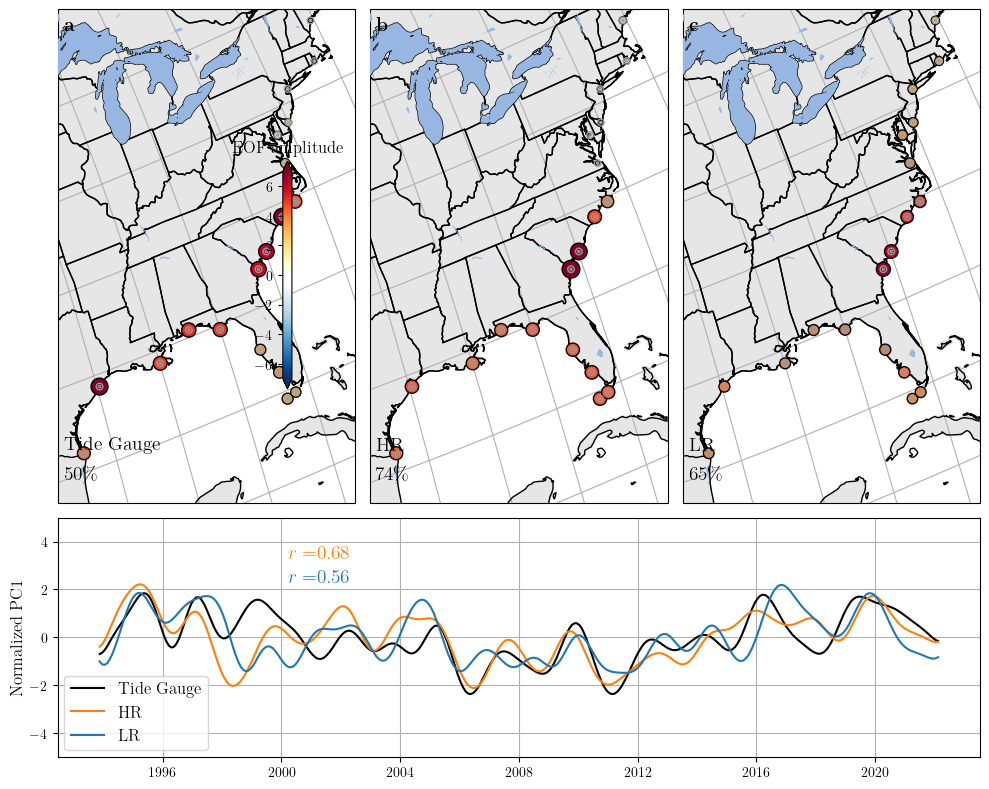

In [43]:
varscale=40
plot_fosi_pcs(pcs,amps,recs_m1,0,vmaxin,varscale)

In [32]:
# implies either there's a source from offshore, or a compensation of coastal shelf signal.

/glade/derecho/scratch/clittle/tmp/ipykernel_22189/21382045.py:105: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


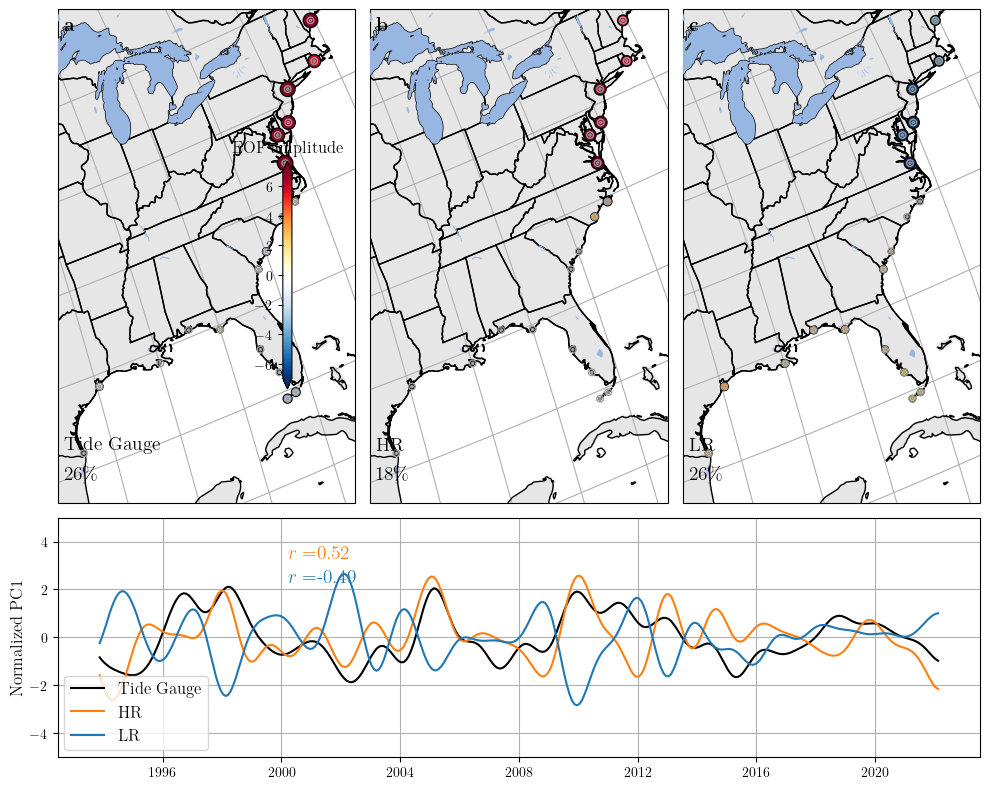

In [44]:
# varscale=500
plot_fosi_pcs_m2(pcs,amps,recs_m2,1,vmaxin,varscale)
# plt.savefig('s3.png',
# )
# varscale=300

In [84]:
# varscale=40
# plot_fosi_pcs_m2(pcs,amps,recs_m2,1,vmaxin+3,varscale)
# # plt.savefig('s3.png',
# # )

In [27]:
from numpy.fft import rfft, irfft
from ssqueezepy import cwt, icwt, Wavelet, padsignal
from ssqueezepy.visuals import plot, plotscat, imshow
from ssqueezepy.experimental import scale_to_freq
import statsmodels.api as sm

In [28]:
def sample_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)

def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]

# Examples.
# print(compute_corr_lag_1(sample_signal(5000, ar_model.params[1])))
# print(np.mean(sample_signal(5000, 0.5, mu=2)))
# print(np.std(sample_signal(5000, 0.5, sigma=3)))# import statsmodels.tsa.ar_model.AutoReg as AutoReg
# train_len = int(0.8*2)
x=pcs[0][0,:].values
train = x
t = np.arange(len(pcs[0].T))

ar_model = sm.tsa.AutoReg(train, lags=1).fit()
print(ar_model.summary())

def calc_ssq_cwt(x, lowper, hiper):

    wavelet = Wavelet(('morlet', {'mu': 6}))  
    wavelet = Wavelet(('gmw'))  
    nv = 32

    n = len(x)
    x_mean = x.mean()

    Wx, scales = cwt(x, wavelet=wavelet, nv=nv)
    freqs = scale_to_freq(scales, wavelet, n, fs=1)
    periods=1/freqs
    power=(np.abs(Wx))**2
    x_inv = icwt(Wx[np.where((periods >= lowper) & (periods <=hiper))], wavelet=wavelet, scales=scales[np.where((periods >= lowper) & (periods <=hiper))], nv=nv, x_mean=x_mean)
    
    return Wx, x_inv, power, periods

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  360
Model:                     AutoReg(1)   Log Likelihood                -469.150
Method:               Conditional MLE   S.D. of innovations              0.894
Date:                Thu, 25 Sep 2025   AIC                            944.301
Time:                        17:56:05   BIC                            955.951
Sample:                             1   HQIC                           948.933
                                  360                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0073      0.047     -0.156      0.876      -0.100       0.085
y.L1           0.4160      0.047      8.792      0.000       0.323       0.509
                                    Roots           

In [30]:
nsig=1
lowper=10
hiper=30

Wx, x_inv, power, periods = calc_ssq_cwt(x, lowper, hiper)
Wpower = np.nan*power
Wpower = np.tile(Wpower[:, :, None], nsig)

for nsamp in np.arange(nsig):
    xin=sample_signal(len(x), ar_model.params[1],x.mean(),x.std())
    Wx, x_inv, power, periods = calc_ssq_cwt(xin, lowper, hiper) #generate synthetic
    if np.mod(nsamp,100)<1:
        print(nsamp)
    Wpower[:,:,nsamp]=power

0


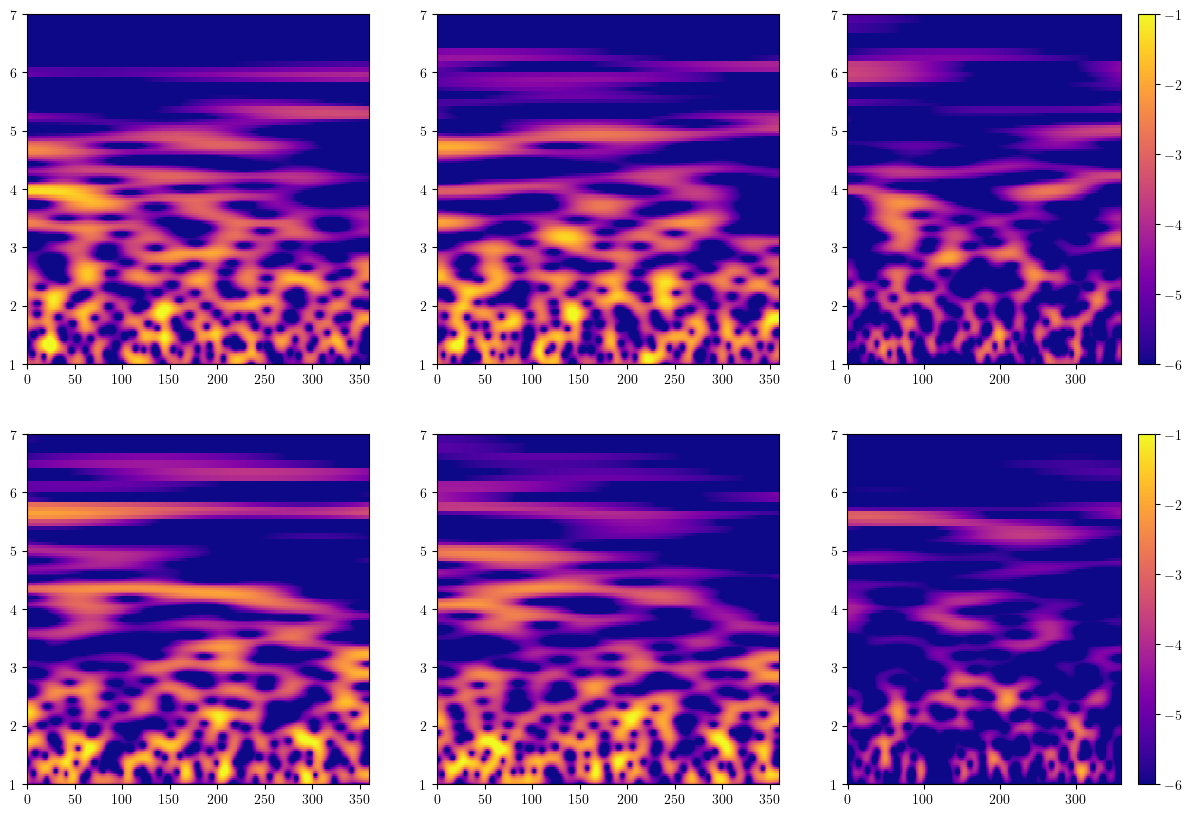

In [43]:
fig=plt.figure(figsize=(15,10))#, tight_layout=True)
levels = np.arange(-6,0,1)
for nmode in np.arange(2):
    for nsim in np.arange(2):
        ax = plt.subplot2grid((2,3), (nmode,nsim), colspan=1, rowspan=1)
        # x=x
        # x=tgin.mean(dim='ens').values
        x=pcs[nsim][nmode,:].values
    
        Wx, x_inv, power, periods = calc_ssq_cwt(x, lowper, hiper) #generate synthetic
        plt.pcolormesh(t, np.log2(periods), np.log2(power), vmin=levels[0], vmax=levels[-1],
                         cmap=plt.cm.plasma)
        # plt.pcolormesh(power.T, vmin=levels[0], vmax=levels[-1],
        #              cmap=plt.cm.plasma)
        plt.ylim(1,7)

    ax = plt.subplot2grid((2,3), (nmode,2), colspan=1, rowspan=1)
        # x=x
        # x=tgin.mean(dim='ens').values
    x=pcs[nsim][nmode,:].values-pcs[nsim-1][nmode,:].values

    Wx, x_inv, power, periods = calc_ssq_cwt(x, lowper, hiper) #generate synthetic
    plt.pcolormesh(t, np.log2(periods), np.log2(power), vmin=levels[0], vmax=levels[-1],
                     cmap=plt.cm.plasma)
    # plt.pcolormesh(power.T, vmin=levels[0], vmax=levels[-1],
    #              cmap=plt.cm.plasma)
    plt.colorbar()
    plt.ylim(1,7)

# peridx=find_nearest(periods, 12)
# ax.plot([t.min(), t.max()],np.log2([periods[peridx], periods[peridx]]),'k')
# peridx=find_nearest(periods, 24)
# ax.plot([t.min(), t.max()],np.log2([periods[peridx], periods[peridx]]),'k')
    # sig1=np.percentile(Wpower,95,axis=2)
    # plt.contour(t, (periods), power>sig1, [-99, 0], colors='k', linewidths=2)
# ax = plt.subplot2grid((1,3), (0, 1), colspan=1, rowspan=1)
# plt.pcolormesh(t, np.log2(periods), Wpower.mean(axis=2), vmin=levels[0], vmax=levels[-1],
#                  cmap=plt.cm.plasma)
# ax = plt.subplot2grid((1,3), (0, 2), colspan=1, rowspan=1)
    # plt.pcolormesh(t, (periods), np.percentile(Wpower,95,axis=2), vmin=levels[0], vmax=levels[-1],
    #                  cmap=plt.cm.plasma)

In [27]:
## mom/buoyancy forced. implications for fixed sensitivities?

In [29]:
# LR

In [125]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh.nc')
da=ssh.ssh.isel(time=slice(edgevals,-edgevals))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


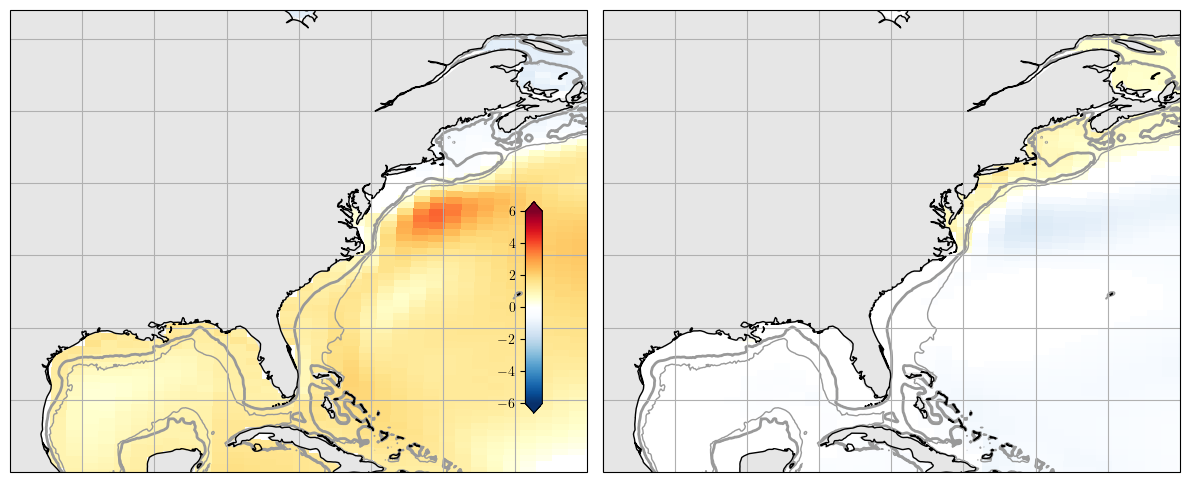

In [126]:
da['time']=pcs[2].time
plot_ssh_reg(pcs[2],da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [127]:
# LOOK FOR whether the pattern is different or the coastal expression

In [128]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_m.nc')
da=ssh.ssh.isel(time=slice(edgevals,-edgevals))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


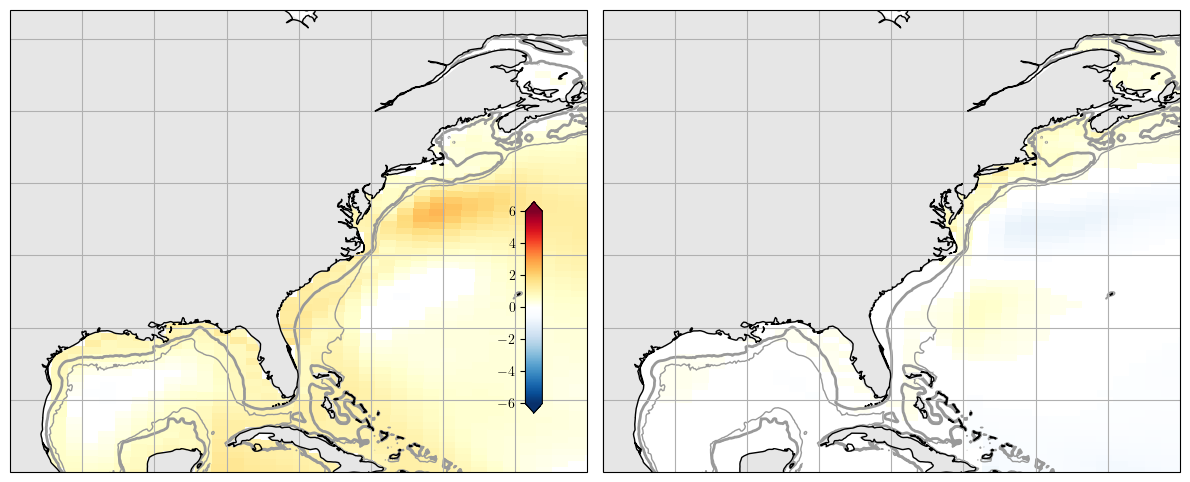

In [129]:
da['time']=pcs[2].time
plot_ssh_reg(pcs[2],da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [131]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_b.nc')
da=ssh.ssh.isel(time=slice(edgevals,-edgevals))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


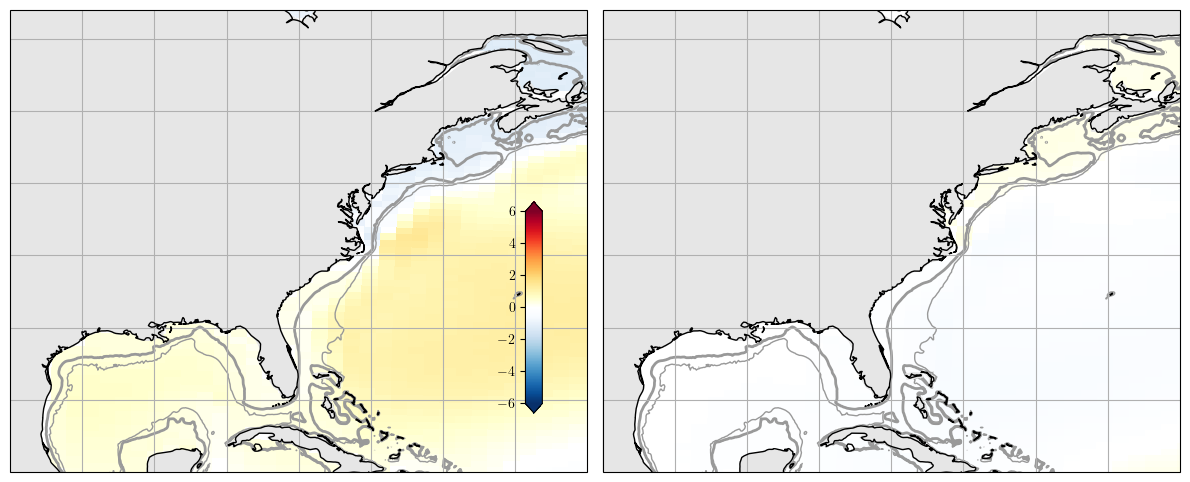

In [132]:
da['time']=pcs[2].time
plot_ssh_reg(pcs[2],da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [133]:
## too much buoyancy forced in LR?

In [118]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh.nc')
da=ssh.ssh.isel(time=slice(edgevals,-edgevals))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


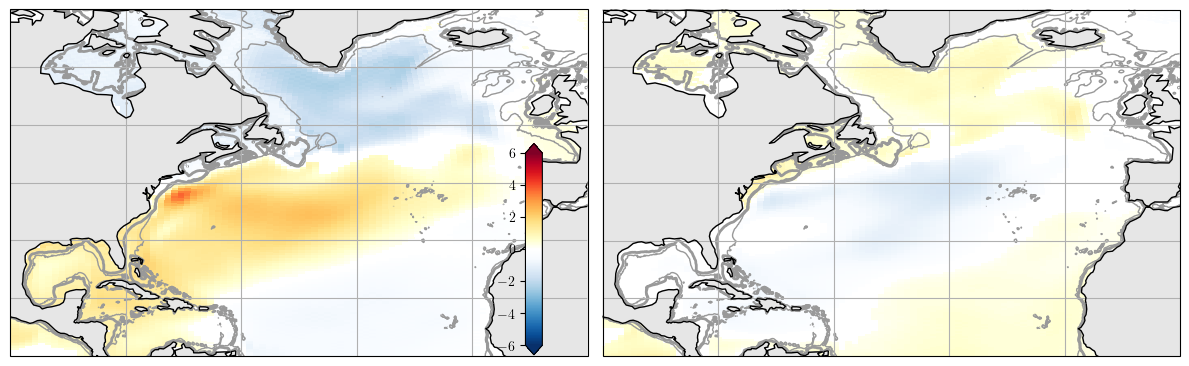

In [119]:
da['time']=pcs[2].time
plot_ssh_reg(pcs[2],da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [112]:
# LOOK FOR whether the pattern is different or the coastal expression

In [120]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_m.nc')
da=ssh.ssh.isel(time=slice(edgevals,-edgevals))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


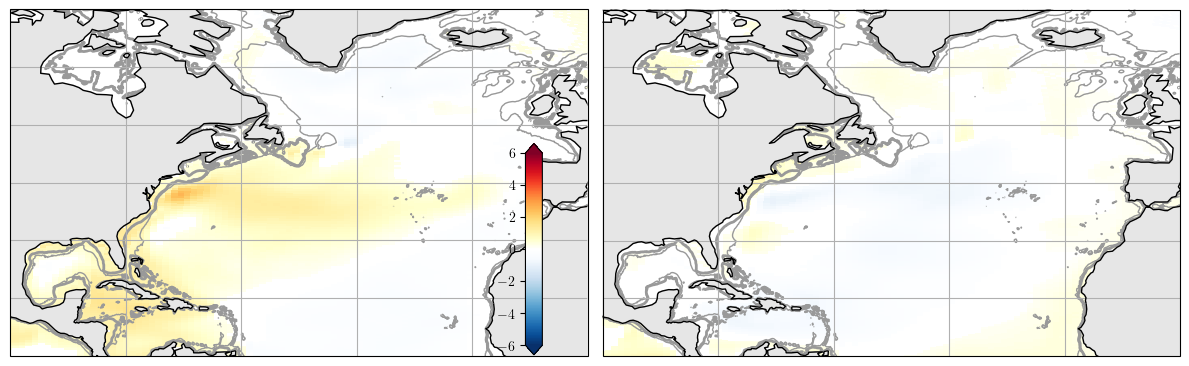

In [121]:
da['time']=pcs[2].time
plot_ssh_reg(pcs[2],da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [122]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_b.nc')
da=ssh.ssh.isel(time=slice(edgevals,-edgevals))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


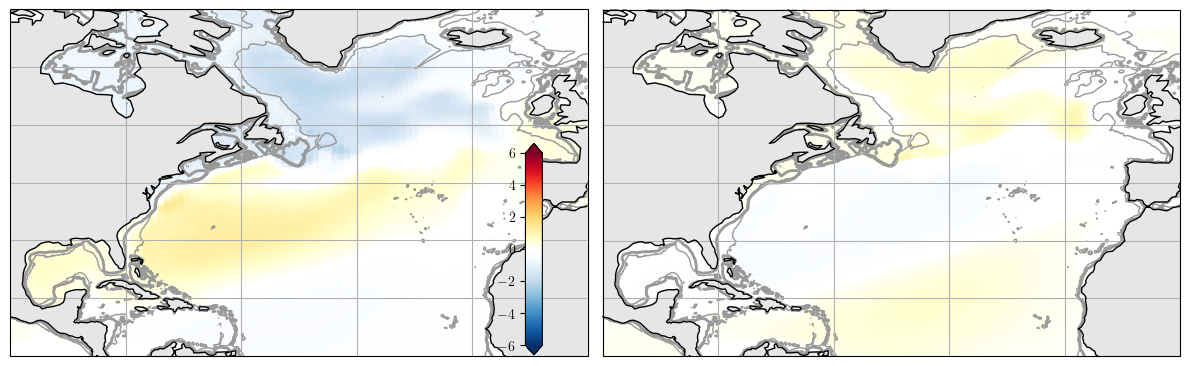

In [123]:
da['time']=pcs[2].time
plot_ssh_reg(pcs[2],da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [47]:
## need to reconcile with ECCO studies! Coastal representation important!!

In [ ]:
## Look at timeseries for total/buoyancy/momentum without modal decomposition.

In [ ]:
# 8 panels, columns model output, then output-TG misfit
# For total, Mom, Buoyancy, Total-M+B, variance, power, etc.

In [12]:
cutoff=35
fs=1
order=5
edgevals=int(np.ceil(cutoff/2))# dain=resid

In [13]:
def lpf_tgs(da):
    daout=filtfilt_bpbutter_2d_low(da,1/cutoff,0*1/3,fs,order,dim='time')
    daout=daout.transpose('time', 'tgindex').load()
    daout=daout.isel(time=slice(edgevals,-edgevals))
    return daout, daout-da

In [14]:
dain1,resid1=lpf_tgs(xr_tg)
dain2,resid2=lpf_tgs(hr_tg)
dain3,resid3=lpf_tgs(lr_tg)

/glade/derecho/scratch/clittle/tmp/ipykernel_122580/917629028.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_122580/917629028.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((3,6), (nsim, nt*2), colspan=2, rowspan=1)


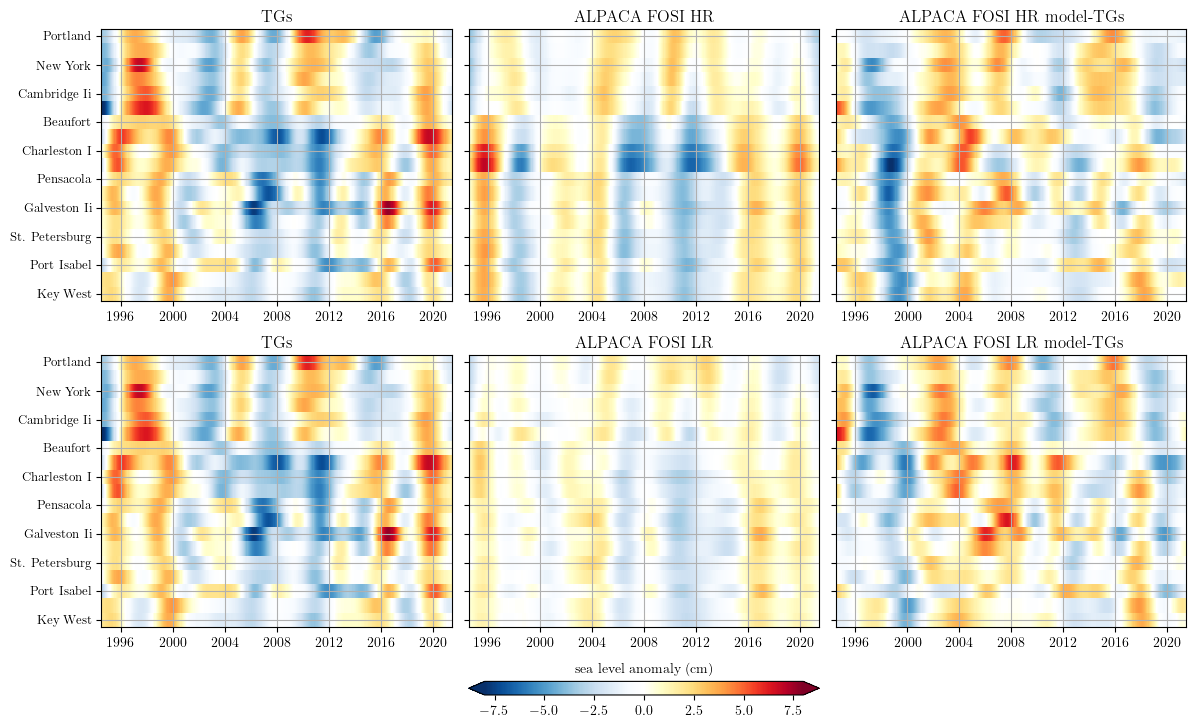

In [25]:
fig = plt.figure(figsize=(14,12))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 2

vmin = -8
vmax2 = -vmin

for nsim in np.arange(2):
    if nsim<1:
        dain=dain2
        tit2="ALPACA FOSI HR"
    else:
        dain=dain3
        tit2="ALPACA FOSI LR"
        
    for nt in np.arange(3):
        if nt<1:
            plotvar=dain1
            tit1="TGs"
        else:
            if nt<2:
                plotvar=dain
                tit1=""
            else:
                plotvar=dain-dain1
                tit1=" model-TGs"
                    
                # if nsim<2:
                #     plotvar=hr_tg.T
                # else:
                #     plotvar=lr_tg.T
    
        ax1 = plt.subplot2grid((3,6), (nsim, nt*2), colspan=2, rowspan=1)
    
        filled1 = ax1.pcolormesh(
            plotvar.time,
            np.arange(0, len(tgnames), 1),
            plotvar.T,
            vmin=vmin,
            vmax=vmax2,
            cmap=cmap,
            shading="nearest",
        )
        # plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
        #                 verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
        # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
    # labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
    # ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
        ticks = np.arange(0, len(tgnames), ylabspacing)
        if nt<1:
            labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
        else:
            labels = []
        ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
        plt.ylim([-.5, len(tgnames)-.5])
        plt.grid()
        if nt>0:
            plt.title(tit2+tit1)
        else:
            plt.title(tit1)
            
        pos = ax1.get_position()  # get the original position
        
        if nt==1:
            cbar_ax = fig.add_axes(
                [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
            )
            cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
            cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
plt.savefig('alpaca_tg_comp.png',
)

/glade/derecho/scratch/clittle/tmp/ipykernel_79671/1674573128.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_79671/1674573128.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_79671/1674573128.py:53: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((4,6), (

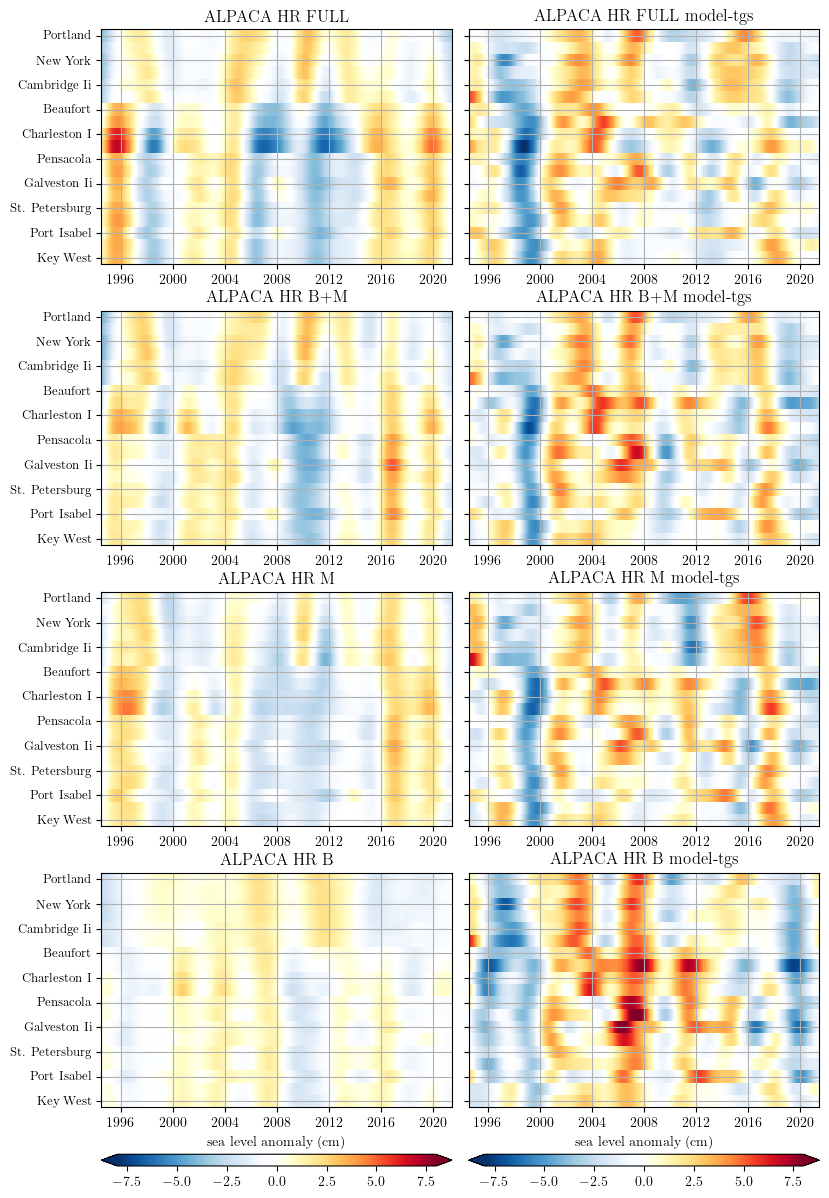

In [32]:
fig = plt.figure(figsize=(14,14))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 2

vmin = -8
vmax2 = -vmin

for nsim in np.arange(4):
    if nsim<1:
        xr_tg=xr.open_dataset('/glade/work/clittle/p2679/tgs_usec_93_22.nc') 
        xr_tg=xr_tg.TG_IB_CORR
        dain_o,resid=lpf_tgs(xr_tg)        
        hr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs.nc')
        hr_tg=hr_tg.ssh
        hr_tg['time']=xr_tg.time
        dain_m,resid=lpf_tgs(hr_tg)
        tit1="ALPACA HR FULL"
    else:
        if nsim<2:
            hr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_m_tgs.nc')
            hr_tg['time']=xr_tg.time
            hr_tg1=hr_tg.ssh
            hr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_b_tgs.nc')
            hr_tg['time']=xr_tg.time
            hr_tg2=hr_tg.ssh            
            dain_m,resid=lpf_tgs(hr_tg1+hr_tg2)
            tit1="ALPACA HR B+M"
        else:
            if nsim<3:
                dain_m,resid=lpf_tgs(hr_tg1)
                tit1="ALPACA HR M"
            else:
                dain_m,resid=lpf_tgs(hr_tg2)
                tit1="ALPACA HR B"
            
    for nt in np.arange(2):
        if nt<1:
            plotvar=dain_m
            tit2=" "
        else:
            plotvar=dain_m-dain_o
            tit2=" model-tgs"
                    
                # if nsim<2:
                #     plotvar=hr_tg.T
                # else:
                #     plotvar=lr_tg.T
    
        ax1 = plt.subplot2grid((4,6), (nsim, nt*2), colspan=2, rowspan=1)
    
        filled1 = ax1.pcolormesh(
            plotvar.time,
            np.arange(0, len(tgnames), 1),
            plotvar.T,
            vmin=vmin,
            vmax=vmax2,
            cmap=cmap,
            shading="nearest",
        )
        # plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
        #                 verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
        # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
    # labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
    # ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
        ticks = np.arange(0, len(tgnames), ylabspacing)
        if nt<1:
            labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
        else:
            labels = []
        ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
        plt.ylim([-.5, len(tgnames)-.5])
        plt.grid()
        plt.title(tit1 + tit2)
        pos = ax1.get_position()  # get the original position
        
        if nsim>1:
            cbar_ax = fig.add_axes(
                [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
            )
            cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
            cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
plt.savefig('alpaca_m_b_usec_comp.png',
)

/glade/derecho/scratch/clittle/tmp/ipykernel_122580/1610130193.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_122580/1610130193.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_122580/1610130193.py:53: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((4,6)

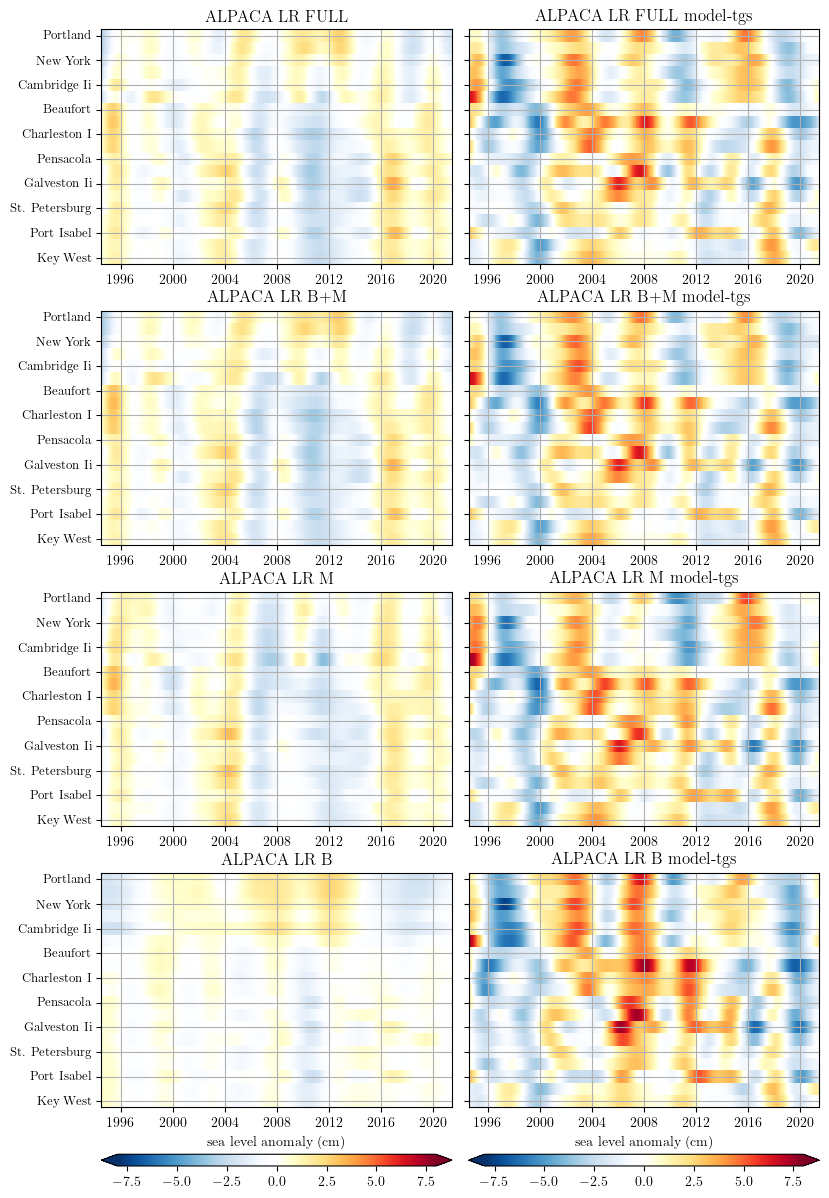

In [16]:
fig = plt.figure(figsize=(14,14))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 2

vmin = -8
vmax2 = -vmin

for nsim in np.arange(4):
    if nsim<1:
        xr_tg=xr.open_dataset('/glade/work/clittle/p2679/tgs_usec_93_22.nc') 
        xr_tg=xr_tg.TG_IB_CORR
        dain_o,resid=lpf_tgs(xr_tg)        
        hr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_lr_ssh_tgs.nc')
        hr_tg=hr_tg.ssh
        hr_tg['time']=xr_tg.time
        dain_m,resid=lpf_tgs(hr_tg)
        tit1="ALPACA LR FULL"
    else:
        if nsim<2:
            hr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_lr_ssh_m_tgs.nc')
            hr_tg['time']=xr_tg.time
            hr_tg1=hr_tg.ssh
            hr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_lr_ssh_b_tgs.nc')
            hr_tg['time']=xr_tg.time
            hr_tg2=hr_tg.ssh            
            dain_m,resid=lpf_tgs(hr_tg1+hr_tg2)
            tit1="ALPACA LR B+M"
        else:
            if nsim<3:
                dain_m,resid=lpf_tgs(hr_tg1)
                tit1="ALPACA LR M"
            else:
                dain_m,resid=lpf_tgs(hr_tg2)
                tit1="ALPACA LR B"
            
    for nt in np.arange(2):
        if nt<1:
            plotvar=dain_m
            tit2=" "
        else:
            plotvar=dain_m-dain_o
            tit2=" model-tgs"
                    
                # if nsim<2:
                #     plotvar=hr_tg.T
                # else:
                #     plotvar=lr_tg.T
    
        ax1 = plt.subplot2grid((4,6), (nsim, nt*2), colspan=2, rowspan=1)
    
        filled1 = ax1.pcolormesh(
            plotvar.time,
            np.arange(0, len(tgnames), 1),
            plotvar.T,
            vmin=vmin,
            vmax=vmax2,
            cmap=cmap,
            shading="nearest",
        )
        # plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
        #                 verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
        # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
    # labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
    # ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
        ticks = np.arange(0, len(tgnames), ylabspacing)
        if nt<1:
            labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
        else:
            labels = []
        ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
        plt.ylim([-.5, len(tgnames)-.5])
        plt.grid()
        plt.title(tit1 + tit2)
        pos = ax1.get_position()  # get the original position
        
        if nsim>1:
            cbar_ax = fig.add_axes(
                [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
            )
            cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
            cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
plt.savefig('alpaca_lr_m_b_usec_comp.png',
)